In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [ ]:
ls /content/drive/MyDrive/practica/data/HAM10000_metadata.csv

/content/drive/MyDrive/practica/data/HAM10000_metadata.csv


In [ ]:
# Cargar el archivo CSV en un DataFrame
ruta_tabular = '/content/drive/MyDrive/practica/data/HAM10000_metadata.csv'
df = pd.read_csv(ruta_tabular)

In [ ]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization       dataset
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp  vidir_modern
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp  vidir_modern
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp  vidir_modern
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp  vidir_modern
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear  vidir_modern

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


## Analizo las variable una a una:  

### dx_type





In [ ]:
df['dx_type'].value_counts()

dx_type
histo        5340
follow_up    3704
consensus     902
confocal       69
Name: count, dtype: int64

In [ ]:
tabla_frecuencia = pd.crosstab(df['dx'], df['dx_type'])
print(tabla_frecuencia)

dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    327
bcc             0          0          0    514
bkl            69        264          0    766
df              0         60          0     55
mel             0          0          0   1113
nv              0        503       3704   2498
vasc            0         75          0     67


In [ ]:
from scipy.stats import chi2_contingency

# Crear tabla de contingencia entre dx_type y dx
contingency_table = pd.crosstab(df['dx_type'], df['dx'])

# Prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2: {chi2}, p-valor: {p}")

Chi2: 4576.809761851324, p-valor: 0.0


Observamos que akiec (queratosis actínica), bcc (carcinoma basocelular) y mel (melanoma) dependen exclusivamente de histopatología y en el caso del método follow_up afecta uni¡camente a nv (nevo benigno). Sendas observaciones muestran que hay una relación fuerte entre dx y dx_type.

Eliminamos ***lesion_id*** y ***image_id***  porque son identificadores sin valor predictivo. En el caso de la variable ***dx_type***, hemos constatsdo una alta correlación con la variable target, el modelo podría aprender esta correlación en lugar de distinguir correctamente otras características (edad, sexo, localización), mejorando su capacidad de generalización.

Selecciono las columnas que me interesan para el análisis

In [ ]:
data =df[['dx', 'age', 'sex', 'localization']].copy()

In [ ]:
data.head()

dx   age   sex localization
0  bkl  80.0  male        scalp
1  bkl  80.0  male        scalp
2  bkl  80.0  male        scalp
3  bkl  80.0  male        scalp
4  bkl  75.0  male          ear

In [ ]:
data.describe()

age
count  9958.000000
mean     51.863828
std      16.968614
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000

### dx o variable target

In [ ]:
data['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Observamos que la clase nv tiene 6705 muestras, mientras que la clase df solo tiene 115, lo que sugiere un fuerte desbalance.

In [ ]:
dx_map = {
    'nv' : 'Lesion benigna',
    'mel' : 'Cancer',
    'bkl' : 'Lesion benigna',
    'bcc' : 'Cancer',
    'akiec' : 'Cancer',
    'vasc' : 'Lesion benigna',
    'df'   : 'Lesion benigna'
}

data['dx_map'] = data['dx'].map(dx_map)

### Age

Únicamente la variable **age** contiene NANs, 57 concretamente.  Dado que la perdida de información asociada a la eliminación de estas 57 obseravaciones frente a un total de  10.015 observaciones no parece relevante, eliminaremos las filas correspondientes.

In [ ]:
df_clean = data.dropna()

La función ***describe*** nos permite ver que la variable **age** tiene 0 como valor mínimo. Esto nos puede llevar a pensar que  este valor corresponda a neonatos, sin embargo, es más probable que **0** sea indicador de valores desconocidos o no informados. Para poder decidir sobre la variable vamos a calcular el porcentaje de veces que la variable **age** toma valor 0 y voy a calculalar la frecuencia con laque la variable toma valor 0.

In [ ]:
data['age'].value_counts()

age
45.0    1299
50.0    1187
55.0    1009
40.0     985
60.0     803
70.0     756
35.0     753
65.0     731
75.0     618
30.0     464
80.0     404
85.0     290
25.0     247
20.0     169
5.0       86
15.0      77
10.0      41
0.0       39
Name: count, dtype: int64

In [ ]:
freq_age_0 = df_clean[df_clean['age'] == 0].shape[0] / df_clean.shape[0]
print(f'La frecuencia de edad 0 es: {freq_age_0 * 100:.2f}%')

La frecuencia de edad 0 es: 0.39%


Dado que la frecuencia de edad 0 es muy baja, se puede considerar que es un error en la base de datos y se puede
eliminar las filas correspondientes.

In [ ]:
df_clean = df_clean.loc[df_clean['age'] != 0]

A continuación, se presenta un histograma que muestra la distribución de edades en el dataset.

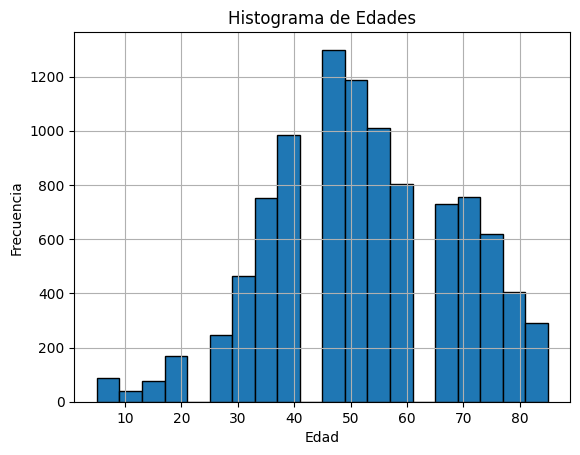

In [ ]:
df_clean['age'].hist(bins=20, edgecolor="black")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.title("Histograma de Edades")
plt.show()

In [ ]:
import pandas as pd

# Ejemplo con la columna 'age' del DataFrame
skewness = df_clean['age'].skew()
print(f"Asimetría (skewness): {skewness}")

Asimetría (skewness): -0.09467111335480957


Una forma categorizar a los pacientes en rangos seria haciendo uso de Jenks para determinar los cortes, el método Jenks Natural Breaks es una técnica de clasificación utilizada para agrupar valores de una variable en clases de manera que la varianza dentro de cada grupo sea mínima y la varianza entre grupos sea máxima. El problema que se deriva del uso de esta técnica es que estas optimizando los grupos para nuestros datos de modo que el modelo pierde robustez.

Para establecer grupos de edad distintos en el conjunto de datos HAM10000, podemos categorizar a los pacientes en rangos significativos según la investigación en dermatología y los patrones epidemiológicos. Un enfoque más robusto que con el método Jenks es agrupar las edades por décadas:  

- Young (<30 years old)  
- Middle-aged (30–45 years old)  
- Pre-senior (46–60 years old)  
- Senior (>60 years old)


In [ ]:

def age_range_mapper(edad):
    if edad < 30:
        return 'Young'
    elif 30 <= edad <= 45:
        return 'Middle_aged'
    elif 46 <= edad <= 60:
        return 'Pre_senior'
    else:
        return 'Senior'

# Aplicar la categorización
df_clean['rango_edad'] = df_clean['age'].apply(age_range_mapper)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Suponiendo que 'X_encoded' es tu DataFrame y 'age_group' la variable categórica
encoder = LabelEncoder()

# Ajustamos el LabelEncoder directamente sobre la columna para aprender las categorías
df_clean['age_group_encoded'] = encoder.fit_transform(df_clean['rango_edad'])

## sex

In [ ]:
df_clean['sex'].value_counts()

sex
male       5377
female     4534
unknown       8
Name: count, dtype: int64

No tendremos en cuenta los valores 'unknown' ya que se corresponde  con valores desconocidos o no informados. Podríamos optar por imputar valores, sin embargo suponen un número muy bajo de las observaciones.

In [ ]:
df_clean = df_clean.loc[df_clean['sex'] != 'unknown']

## localization

In [ ]:
df_clean['localization'].value_counts()

localization
back               2185
lower extremity    2069
trunk              1400
upper extremity    1110
abdomen            1016
face                741
chest               403
foot                306
unknown             187
neck                168
scalp               127
hand                 90
ear                  54
genital              48
acral                 7
Name: count, dtype: int64

Voy a observar las filas en las que la variable localization tiene un valor de 'unknown' para ver si extraigo alguna conclusión.

In [ ]:
df_clean[df_clean['localization'] == 'unknown']

dx   age     sex localization          dx_map   rango_edad  age_group_encoded
50    bkl  80.0  female      unknown  Lesion benigna       Senior                  2
56    bkl  75.0    male      unknown  Lesion benigna       Senior                  2
57    bkl  75.0    male      unknown  Lesion benigna       Senior                  2
140   bkl  65.0    male      unknown  Lesion benigna       Senior                  2
461   bkl  50.0    male      unknown  Lesion benigna   Pre_senior                  1
511   bkl  80.0  female      unknown  Lesion benigna       Senior                  2
535   bkl  60.0    male      unknown  Lesion benigna   Pre_senior                  1
821   bkl  40.0    male      unknown  Lesion benigna  Middle_aged                  0
822   bkl  40.0    male      unknown  Lesion benigna  Middle_aged                  0
967   bkl  60.0    male      unknown  Lesion benigna   Pre_senior                  1
1280  mel  75.0    male      unknown          Cancer       Senior                  2
1281  mel  75.0    male      unknown          Cancer       Senior                  2
1286  mel  70.0    male      unknown          Cancer       Senior                  2
1287  mel  70.0    male      unknown          Cancer       Senior                  2
1322  mel  80.0    male      unknown          Cancer       Senior                  2
1323  mel  80.0    male      unknown          Cancer       Senior                  2
1338  mel  75.0    male      unknown          Cancer       Senior                  2
1344  mel  45.0    male      unknown          Cancer  Middle_aged                  0
1345  mel  45.0    male      unknown          Cancer  Middle_aged                  0
1400  mel  75.0  female      unknown          Cancer       Senior                  2
2657  bcc  45.0  female      unknown          Cancer  Middle_aged                  0
2658  bcc  45.0  female      unknown          Cancer  Middle_aged                  0
2735  bcc  60.0    male      unknown          Cancer   Pre_senior                  1
2969  bcc  70.0    male      unknown          Cancer       Senior                  2
2970  bcc  70.0    male      unknown          Cancer       Senior                  2
3819   nv  50.0  female      unknown  Lesion benigna   Pre_senior                  1
4078   nv  70.0    male      unknown  Lesion benigna       Senior                  2
4107   nv  55.0  female      unknown  Lesion benigna   Pre_senior                  1
4142   nv  60.0  female      unknown  Lesion benigna   Pre_senior                  1
4579   nv  60.0  female      unknown  Lesion benigna   Pre_senior                  1
4644   nv  50.0  female      unknown  Lesion benigna   Pre_senior                  1
4752   nv  50.0    male      unknown  Lesion benigna   Pre_senior                  1
4828   nv  55.0  female      unknown  Lesion benigna   Pre_senior                  1
5135   nv  45.0  female      unknown  Lesion benigna  Middle_aged                  0
5186   nv  55.0  female      unknown  Lesion benigna   Pre_senior                  1
6773   nv  25.0  female      unknown  Lesion benigna        Young                  3
6774   nv  25.0  female      unknown  Lesion benigna        Young                  3
6846   nv  55.0  female      unknown  Lesion benigna   Pre_senior                  1
6847   nv  55.0  female      unknown  Lesion benigna   Pre_senior                  1
6862   nv  35.0  female      unknown  Lesion benigna  Middle_aged                  0
6863   nv  35.0  female      unknown  Lesion benigna  Middle_aged                  0
6866   nv  35.0  female      unknown  Lesion benigna  Middle_aged                  0
6867   nv  35.0  female      unknown  Lesion benigna  Middle_aged                  0
6912   nv  30.0    male      unknown  Lesion benigna  Middle_aged                  0
6913   nv  30.0    male      unknown  Lesion benigna  Middle_aged                  0
6971   nv  85.0  female      unknown  Lesion benigna       Senior                  2
6972   nv  8

No advertimos ningún patron y no tendremos en cuenta los valores 'unknown'. Unicamente existen 187 registros con este valor, por lo que no afectará significativamente al análisis.

In [ ]:
df_clean = df_clean.loc[df_clean['localization'] != 'unknown']

Vamos a agrupar esta variable en: Torso, extremidades, 'cabeza y cuello', genitales, y 'dedos,manos pies'

In [ ]:
localization_mapper = {
    "back": "Torso",
    "trunk": "Torso",
    "chest": "Torso",
    "abdomen": "Torso",
    "lower extremity": "Extremidades",
    "upper extremity": "Extremidades",
    "foot": "Dedos, manos y pies",
    "hand": "Dedos, manos y pies",
    "face": "Cabeza y cuello",
    "scalp": "Cabeza y cuello",
    "neck": "Cabeza y cuello",
    "ear": "Cabeza y cuello",
    "genital": "Genitales",
    "acral": "Dedos, manos y pies",
}

# Aplicar el mapeo en el DataFrame
df_clean["localization_grouped"] = df_clean["localization"].map(localization_mapper)

<p style="font-size:14px">
Creo dos funciones (<span style="font-style:italic; font-weight:bold">Una de ellas para el caso específico del modelo en el que uso embeddings</span>) para almacenar las métricas de cada uno de los modelos para posteriormente poder compararlos.
</p>

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

In [ ]:
def get_full_model_metrics_embeddings(H, model, X_val, y_val, model_name):
    from sklearn.metrics import classification_report
    import pandas as pd

    # List of class names
    class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

    # Predecir como hiciste antes (diccionario por entrada)
    X_val_dict = {
        "rango_edad_input": X_val["rango_edad_encoded"],
        "sexo_input": X_val["sexo_encoded"],
        "localization_input": X_val["localization_encoded"]
    }

    y_pred = model.predict(X_val_dict)
    y_true = y_val.argmax(axis=1)
    y_pred_labels = y_pred.argmax(axis=1)

    # Reporte detallado
    report = classification_report(y_true, y_pred_labels, output_dict=True, zero_division=0,
                                  target_names=class_names)

    # Flatten the report with class names
    report_flat = {}
    for key, value in report.items():
        if isinstance(value, dict):
            for metric, metric_value in value.items():
                # Use the actual class name instead of the index
                report_flat[f"{key}_{metric}"] = metric_value

    # Solo la última época
    last_epoch_metrics = {k: v[-1] for k, v in H.history.items()}
    last_epoch_metrics["model"] = model_name
    full_result = {**last_epoch_metrics, **report_flat}

    return pd.DataFrame([full_result])

In [ ]:
def get_full_model_metrics(H, model, X_val, y_val, model_name="modelo", class_labels=None):

    from sklearn.metrics import classification_report

    # 1. Obtener métricas de la última época
    last_epoch = len(H.history["loss"]) - 1

    # Definir métricas base que siempre deben estar
    last_epoch_metrics = {
        "loss": H.history["loss"][-1],
        "accuracy": H.history["accuracy"][-1],
        "val_loss": H.history["val_loss"][-1],
        "val_accuracy": H.history["val_accuracy"][-1],
        "epoch": last_epoch,
        "model": model_name
    }

    # Añadir learning_rate solo si existe
    if 'lr' in H.history:
        last_epoch_metrics["learning_rate"] = H.history['lr'][-1]

    # 2. Obtener predicciones
    y_pred = model.predict(X_val, verbose=0)
    y_true = y_val.argmax(axis=1)
    y_pred_labels = y_pred.argmax(axis=1)

    # 3. Obtener classification_report
    report_dict = classification_report(
        y_true,
        y_pred_labels,
        output_dict=True,
        zero_division=0
    )

    # 4. Aplanar el reporte
    flat_report = {}
    for key, value in report_dict.items():
        label_name = class_labels[int(key)] if (key.isdigit() and class_labels) else key

        if isinstance(value, dict):
            for metric, val in value.items():
                flat_report[f"{label_name}_{metric}"] = val
        else:
            flat_report[label_name] = value

    # 5. Combinar todo
    full_metrics = {**last_epoch_metrics, **flat_report}

    # 6. Crear DataFrame con conversión segura de tipos
    df = pd.DataFrame([full_metrics])

    # Convertir solo las columnas que existen
    type_conversion = {
        'loss': 'float32',
        'accuracy': 'float32',
        'val_loss': 'float32',
        'val_accuracy': 'float32'
    }

    # Añadir learning_rate solo si está presente
    if 'learning_rate' in df.columns:
        type_conversion['learning_rate'] = 'float32'

    return df.astype({col: dtype for col, dtype in type_conversion.items() if col in df.columns})

## Modelo tabular clasificador multiclase 7 clases  
#### Utilizando la técnica de embedings para las variables independientes.



Dado que estás utilizando embeddings para variables categóricas, debemos usar Model() en lugar de Sequential(), ya que Sequential() solo acepta una única entrada.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2, l1
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
features = ['sex', 'localization_grouped', 'rango_edad']
X = df_clean[features]
y = df_clean['dx']

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Dividimos el conjunto de training en training y validation #(X)
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# 2. Inicializar encoders
age_encoder = LabelEncoder()
sex_encoder = LabelEncoder()
localization_encoder = LabelEncoder()

# 3. Ajustar SOLO con datos de entrenamiento
# --- Aplicar fit_transform en train ---
x_tr.loc[:, "rango_edad_encoded"] = age_encoder.fit_transform(x_tr["rango_edad"])
x_tr.loc[:, "sexo_encoded"] = sex_encoder.fit_transform(x_tr["sex"])
x_tr.loc[:, "localization_encoded"] = localization_encoder.fit_transform(x_tr["localization_grouped"])

# --- Aplicar transform en validation (sin fit) ---
x_val.loc[:, "rango_edad_encoded"] = age_encoder.transform(x_val["rango_edad"])
x_val.loc[:, "sexo_encoded"] = sex_encoder.transform(x_val["sex"])
x_val.loc[:, "localization_encoded"] = localization_encoder.transform(x_val["localization_grouped"])

# Verificar mapeo (solo train)
print("Mapeo de rango_edad:", dict(enumerate(age_encoder.classes_)))
print("Mapeo de sexo:", dict(enumerate(sex_encoder.classes_)))
print("Mapeo de localization_grouped:", dict(enumerate(localization_encoder.classes_)))


embedding_dims = {
    "rango_edad": 4,  # sqrt(4 categorías) ≈ 2-4 dimensiones
    "sexo": 2,        # sqrt(2 categorías) ≈ 1-2 dimensiones
    "localization": 8 # sqrt(5 categorías agrupadas) ≈ 3-8 dimensiones
}

# Convertir etiquetas a enteros
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_tr)
y_val_encoded = label_encoder.transform(y_val)
print(label_encoder.classes_)

# One-Hot para la variable objetivo (si es necesario)
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes=num_classes)


Mapeo de rango_edad: {0: 'Middle_aged', 1: 'Pre_senior', 2: 'Senior', 3: 'Young'}
Mapeo de sexo: {0: 'female', 1: 'male'}
Mapeo de localization_grouped: {0: 'Cabeza y cuello', 1: 'Dedos, manos y pies', 2: 'Extremidades', 3: 'Genitales', 4: 'Torso'}
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [ ]:
from tensorflow.keras.layers import Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def train_deep_net(activation_function, learning_rate, batch_size, num_epochs):
    dropout_rates = [0.50, 0.40, 0.30, 0.20]

    # Definir inputs para cada variable categórica
    input_age = Input(shape=(1,), name="rango_edad_input")
    input_sex = Input(shape=(1,), name="sexo_input")
    input_localization = Input(shape=(1,), name="localization_input")

    # Definir capas de embedding
    embedding_age = Embedding(input_dim=len(age_encoder.classes_), output_dim=4)(input_age)
    embedding_sex = Embedding(input_dim=len(sex_encoder.classes_), output_dim=2)(input_sex)
    embedding_localization = Embedding(input_dim=len(localization_encoder.classes_), output_dim=8)(input_localization)

    # Aplanar los embeddings
    flatten_age = Flatten()(embedding_age)
    flatten_sex = Flatten()(embedding_sex)
    flatten_localization = Flatten()(embedding_localization)

    # Concatenar embeddings
    merged = Concatenate()([flatten_age, flatten_sex, flatten_localization])

    # **Modelo con múltiples inputs (usando Model())**
    x = Dense(256, activation=activation_function, kernel_regularizer=l2(0.02))(merged)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[1])(x)
    x = Dense(128, activation=activation_function, kernel_regularizer=l2(0.02))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[1])(x)
    x = Dense(64, activation=activation_function, kernel_regularizer=l2(0.02))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[1])(x)
    x = Dense(32, activation=activation_function, kernel_regularizer=l2(0.02))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[1])(x)
    output = Dense(7, activation='softmax')(x)  # Capa de salida con 7 clases

    # **Definir modelo con múltiples entradas**
    model = Model(inputs=[input_age, input_sex, input_localization], outputs=output)

    # Callbacks para regularización
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5)

    # Compilar modelo
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    print("[INFO]: Entrenando red neuronal...")

    # Entrenar el modelo
    H = model.fit(
        {"rango_edad_input": x_tr["rango_edad_encoded"],
         "sexo_input": x_tr["sexo_encoded"],
         "localization_input": x_tr["localization_encoded"]},
        y_train_onehot,
        validation_data=(
            {"rango_edad_input": x_val["rango_edad_encoded"],
             "sexo_input": x_val["sexo_encoded"],
             "localization_input": x_val["localization_encoded"]},
            y_val_onehot
        ),
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Evaluar modelo
    print("[INFO]: Evaluando red neuronal...")
    predictions = model.predict(
        {"rango_edad_input": x_val["rango_edad_encoded"],
         "sexo_input": x_val["sexo_encoded"],
         "localization_input": x_val["localization_encoded"]},
        batch_size=batch_size
    )

    # Reporte de clasificación
    print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))


    full_df = get_full_model_metrics_embeddings(
        H= H,
        model= model,
        X_val= x_val,
        y_val= y_val_onehot,
        model_name= "Modelo tabular clasificador multiclase 7 clases haciendo uso de embeddings",

    )

    # Ver y guardar
    print(full_df.head())
    full_df.to_csv("multiclass_embedding_model_metrics.csv", index=False)

    # Guardar la arquitectura del modelo
    model_json = model.to_json()
    with open("multiclass_embedding_model_architecture.json", "w") as json_file:
        json_file.write(model_json)

    # Guardar los pesos del modelo
    model.save_weights("multiclass_embedding_model.weights.h5")

    # Guardar los resultados en un DataFrame
    history_df = pd.DataFrame(H.history)
    history_df.to_csv("multiclass_embedding_model.csv", index=False)

    # Gráfica de loss y accuracy
    plt.style.use("ggplot")
    epochs = len(H.history["loss"])
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

[INFO]: Entrenando red neuronal...
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.1874 - loss: 9.0684 - val_accuracy: 0.0401 - val_loss: 7.7972 - learning_rate: 5.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3150 - loss: 7.9080 - val_accuracy: 0.6607 - val_loss: 7.0518 - learning_rate: 5.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4075 - loss: 7.0221 - val_accuracy: 0.6530 - val_loss: 6.3165 - learning_rate: 5.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4526 - loss: 6.2868 - val_accuracy: 0.6530 - val_loss: 5.6252 - learning_rate: 5.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4929 - loss: 5.5932 - val_accuracy: 0.6530 - val_loss: 5.0083 - learning_rate: 5.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5293 - loss: 5.0014 - val_accuracy: 0.6530 - val_loss: 4.4747 - learning_rate: 5.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 

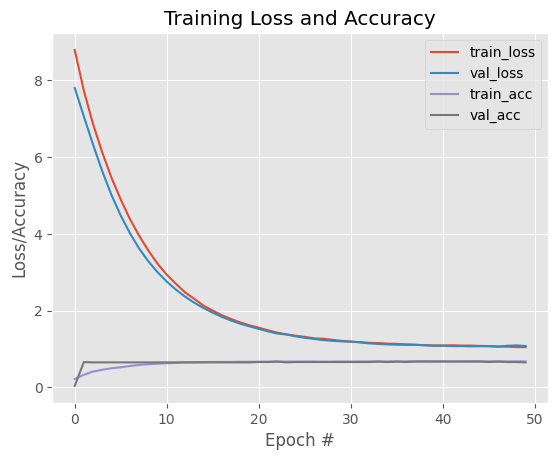

In [ ]:
act = tf.nn.leaky_relu
learning_rate = 0.0005
lr_decay = 1e-4
num_epochs = 50
batch_size  = 256
train_deep_net(act, learning_rate, batch_size, num_epochs)

## Modelo tabular clasificador multiclase 7 clases  
### Utilizando la técnica de one hot encoding para las variables independientes.
#### Sin aplicar ajuste de pesos de clase (class_weight).



In [ ]:
features = ['sex', 'localization_grouped', 'rango_edad']
X = df_clean[features]
y = df_clean['dx']

In [ ]:
# Dividimos el conjunto de training en training y validation #(X)
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

from sklearn.preprocessing import LabelEncoder

# Convertir etiquetas a enteros
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_tr)
y_val_encoded = label_encoder.transform(y_val)
print(label_encoder.classes_)

# One-Hot para la variable objetivo (si es necesario)
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes=num_classes)

# Crear y ajustar el OneHotEncoder
# TensorFlow/Keras espera como entrada arrays densos (no matrices dispersas) para entrenar modelos.
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
x_tr_encoded = encoder.fit_transform(x_tr)
x_val_encoded = encoder.transform(x_val)


['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [ ]:
# definimos la función para entrenar nuestra red con los parámetros deseados
def train_deep_net(activation_function, learning_rate, batch_size, num_epochs):

  # Implementamos la red empleando Keras

  dropout_rates = [0.50, 0.40, 0.30, 0.20]

  input_dim = x_tr_encoded.shape[1]
  print(f'input_dim: {input_dim}')


  model = Sequential()
  model.add(Input(shape=(input_dim,)))  # Capa Input explícita
  model.add(Dense(512, activation=activation_function,))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[0]))
  model.add(Dense(256, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[1]))
  model.add(Dense(128, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[1]))
  model.add(Dense(64, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(32, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(7, activation='softmax'))  # Capa de salida con 7 neuronas y activación softmax

  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
  )

  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  #tf.keras.optimizers.Adam(learning_rate=learning_rate)
  #tf.keras.optimizers.SGD(learning_rate=learning_rate)
  lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
  opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  model.compile(loss= "categorical_crossentropy" , optimizer=opt, metrics=["accuracy"])  #(X)

  # Entrenando la solución
  H = model.fit(x_tr_encoded, y_train_onehot, validation_data=(x_val_encoded, y_val_onehot), epochs=num_epochs, callbacks=[early_stopping, lr_scheduler])  #(X)

  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x_val_encoded, batch_size=batch_size)
  #print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
  print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

  class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
  full_df = get_full_model_metrics(
    H=H,
    model=model,
    X_val=x_val_encoded,  # Use the encoded version, not x_val
    y_val=y_val_onehot,
    model_name="Modelo tabular clasificador multiclase 7 clases codificando las variables categóricas con OneHotEncoder",
    class_labels=class_labels
  )
  # Ver y guardar
  print(full_df.head())
  full_df.to_csv("multiclass_model_onehot_metrics.csv", index=False)

  # Guardar la arquitectura del modelo
  model_json = model.to_json()
  with open("multiclass_model_onehot_architecture.json", "w") as json_file:
      json_file.write(model_json)

    # Guardar los pesos del modelo
  model.save_weights("multiclass_model_onehot.weights.h5")

    # Guardar los resultados en un DataFrame
  history_df = pd.DataFrame(H.history)
  history_df.to_csv("multiclass_model_onehot_history.csv", index=False)

  # Muestro gráfica de accuracy y lossen

  plt.style.use("ggplot")
  epochs = len(H.history["loss"])
  plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()



input_dim: 11
[INFO]: Entrenando red neuronal...
Epoch 1/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.1860 - loss: 8.6276 - val_accuracy: 0.1059 - val_loss: 7.8949 - learning_rate: 2.0000e-04
Epoch 2/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3761 - loss: 7.4833 - val_accuracy: 0.5481 - val_loss: 6.7379 - learning_rate: 2.0000e-04
Epoch 3/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4969 - loss: 6.6024 - val_accuracy: 0.6170 - val_loss: 5.8475 - learning_rate: 2.0000e-04
Epoch 4/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5651 - loss: 5.8486 - val_accuracy: 0.6519 - val_loss: 5.1777 - learning_rate: 2.0000e-04
Epoch 5/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6201 - loss: 5.1950 - val_accuracy: 0.6560 - val_loss: 4.5964 - learning_rate: 2.0000e-04
Epoch 6/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6281 - loss: 4.6409 - val_accuracy: 0.6879 - val_loss: 4.0917 - learning_rate: 2.0000e-04
Epoch 7/50
24

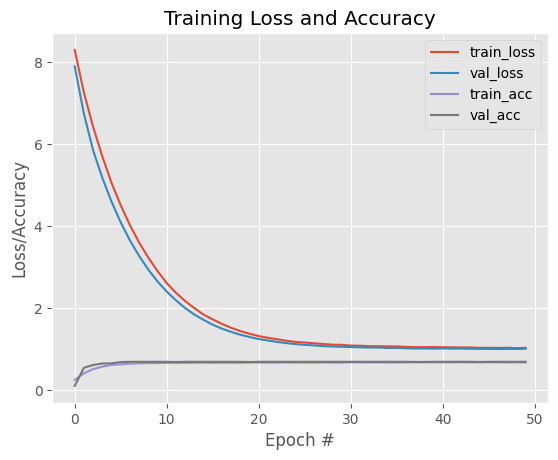

In [ ]:
act = tf.nn.leaky_relu
learning_rate = 0.0002
num_epochs = 50
batch_size  = 256
train_deep_net(act, learning_rate, batch_size, num_epochs)

## Modelo tabular clasificador multiclase 7 clases  
### Utilizando la técnica de one hot encoding para las variables independientes.
#### Aplicando Ajuste de pesos de clase (class_weight).



In [ ]:
# definimos la función para entrenar nuestra red con los parámetros deseados
def train_deep_net(activation_function, learning_rate, batch_size, num_epochs):

  # Implementamos la red empleando Keras

  dropout_rates = [0.50, 0.40, 0.30, 0.20]

  input_dim = x_tr_encoded.shape[1]


  model = Sequential()
  model.add(Input(shape=(input_dim,)))  # Capa Input explícita
  model.add(Dense(512, activation=activation_function,))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[0]))
  model.add(Dense(256, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[1]))
  model.add(Dense(128, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[1]))
  model.add(Dense(64, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(32, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(7, activation='softmax'))  # Capa de salida con 7 neuronas y activación softmax

  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
  )

  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  #tf.keras.optimizers.Adam(learning_rate=learning_rate)
  #tf.keras.optimizers.SGD(learning_rate=learning_rate)
  lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
  opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  model.compile(loss= "categorical_crossentropy" , optimizer=opt, metrics=["accuracy"])  #(X)

  class_weights = compute_class_weight("balanced", classes=np.unique(y_tr), y=y_tr)
  class_weight_dict = {i: w for i, w in enumerate(class_weights)}


  # Entrenando la solución
  H = model.fit(x_tr_encoded, y_train_onehot, validation_data=(x_val_encoded, y_val_onehot), epochs=num_epochs, class_weight=class_weight_dict, callbacks=[early_stopping, lr_scheduler])  #(X)

  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x_val_encoded, batch_size=batch_size)
  #print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
  print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

  class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
  full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= x_val_encoded,
        y_val= y_val_onehot,
        model_name= "Modelo tabular clasificador multiclase 7 clases  haciendo uso de OneHotEncoder y class_weight",
        class_labels= class_labels
    )

  # Ver y guardar
  print(full_df.head())
  full_df.to_csv("multiclass_model_onehot_class_weight_metrics.csv", index=False)

  # Guardar la arquitectura del modelo
  model_json = model.to_json()
  with open("multiclass_model_onehot_class_weight_architecture.json", "w") as json_file:
      json_file.write(model_json)

    # Guardar los pesos del modelo
  model.save_weights("multiclass_model_onehot_class_weight.weights.h5")

    # Guardar los resultados en un DataFrame
  history_df = pd.DataFrame(H.history)
  history_df.to_csv("multiclass_model_onehot_class_weight_history.csv", index=False)

  # Muestro gráfica de accuracy y lossen

  plt.style.use("ggplot")
  epochs = len(H.history["loss"])
  plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()



[INFO]: Entrenando red neuronal...
Epoch 1/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.1721 - loss: 8.7942 - val_accuracy: 0.1306 - val_loss: 7.6766 - learning_rate: 5.0000e-04
Epoch 2/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2170 - loss: 7.8670 - val_accuracy: 0.3712 - val_loss: 6.9429 - learning_rate: 5.0000e-04
Epoch 3/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2315 - loss: 7.1814 - val_accuracy: 0.3404 - val_loss: 6.3542 - learning_rate: 5.0000e-04
Epoch 4/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2405 - loss: 6.3299 - val_accuracy: 0.3378 - val_loss: 5.7361 - learning_rate: 5.0000e-04
Epoch 5/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2404 - loss: 5.6859 - val_accuracy: 0.3491 - val_loss: 5.1458 - learning_rate: 5.0000e-04
Epoch 6/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2636 - loss: 5.1740 - val_accuracy: 0.4051 - val_loss: 4.6452 - learning_rate: 5.0000e-04
Epoch 7/50
244/244 ━━━━━━━━

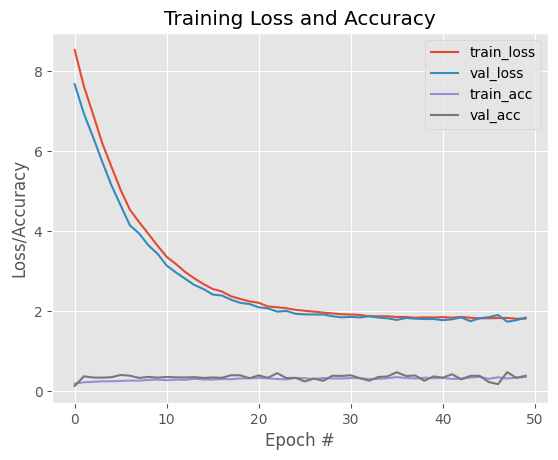

In [ ]:
act = tf.nn.leaky_relu
learning_rate = 0.0005
num_epochs = 50
batch_size  = 256
train_deep_net(act, learning_rate, batch_size, num_epochs)

## Modelo tabular clasificador binario.

In [ ]:
features = ['sex', 'localization_grouped', 'rango_edad']
X = df_clean[features]
y = df_clean['dx_map']

In [ ]:
# Dividimos el conjunto de training en training y validation #(X)
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder

# Convertir etiquetas a enteros
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_tr)
y_val_encoded = label_encoder.transform(y_val)
print(label_encoder.classes_)

# One-Hot para la variable objetivo (si es necesario)
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes=num_classes)

# Crear y ajustar el OneHotEncoder
# TensorFlow/Keras espera como entrada arrays densos (no matrices dispersas) para entrenar modelos.
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
x_tr_encoded = encoder.fit_transform(x_tr)
x_val_encoded = encoder.transform(x_val)


['Cancer' 'Lesion benigna']


In [ ]:
# definimos la función para entrenar nuestra red con los parámetros deseados
def train_deep_net(activation_function, learning_rate, batch_size, num_epochs):


  # Implementamos la red empleando Keras

  dropout_rates = [0.50, 0.40, 0.30, 0.20]

  input_dim = x_tr_encoded.shape[1]


  model = Sequential()
  model.add(Input(shape=(input_dim,)))  # Capa Input explícita
  model.add(Dense(256, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(128, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(128, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(64, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(64, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(32, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(64, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(32, activation=activation_function, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(2, activation='softmax'))  # Capa de salida con 7 neuronas y activación softmax

  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 15, restore_best_weights=True
  )

  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  #tf.keras.optimizers.Adam(learning_rate=learning_rate)
  #tf.keras.optimizers.SGD(learning_rate=learning_rate)
  lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=10)
  opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  model.compile(loss= "binary_crossentropy" , optimizer=opt, metrics=["accuracy"])  #(X)


  # Entrenando la solución
  H = model.fit(x_tr_encoded, y_train_onehot, validation_data=(x_val_encoded, y_val_onehot), epochs=num_epochs, callbacks=[early_stopping, lr_scheduler])  #(X)


  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x_val_encoded, batch_size=batch_size)
  #print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
  print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

  class_labels = ['Cancer', 'Lesion benigna']
  full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= x_val_encoded,
        y_val= y_val_onehot,
        model_name= "Modelo tabular clasificador binario",
        class_labels= class_labels
    )

  # Ver y guardar
  print(full_df.head())
  full_df.to_csv("binary_model_metrics.csv", index=False)


  # Guardar la arquitectura del modelo
  model_json = model.to_json()
  with open("binary_model_architecture.json", "w") as json_file:
      json_file.write(model_json)

    # Guardar los pesos del modelo
  model.save_weights("binary_model.weights.h5")

    # Guardar los resultados en un DataFrame
  history_df = pd.DataFrame(H.history)
  history_df.to_csv("binary_model_history.csv", index=False)


  # Muestro gráfica de accuracy y lossen

  plt.style.use("ggplot")
  epochs = len(H.history["loss"])
  plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()


[INFO]: Entrenando red neuronal...
Epoch 1/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.5337 - loss: 6.6301 - val_accuracy: 0.7949 - val_loss: 5.9299 - learning_rate: 2.0000e-04
Epoch 2/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6378 - loss: 5.9183 - val_accuracy: 0.7887 - val_loss: 5.3542 - learning_rate: 2.0000e-04
Epoch 3/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6933 - loss: 5.3559 - val_accuracy: 0.7907 - val_loss: 4.9336 - learning_rate: 2.0000e-04
Epoch 4/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7293 - loss: 4.9438 - val_accuracy: 0.8000 - val_loss: 4.5685 - learning_rate: 2.0000e-04
Epoch 5/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7627 - loss: 4.5610 - val_accuracy: 0.8000 - val_loss: 4.2455 - learning_rate: 2.0000e-04
Epoch 6/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7803 - loss: 4.2388 - val_accuracy: 0.8000 - val_loss: 3.9807 - learning_rate: 2.0000e-04
Epoch 7/50
244/244 ━━━━━━━━

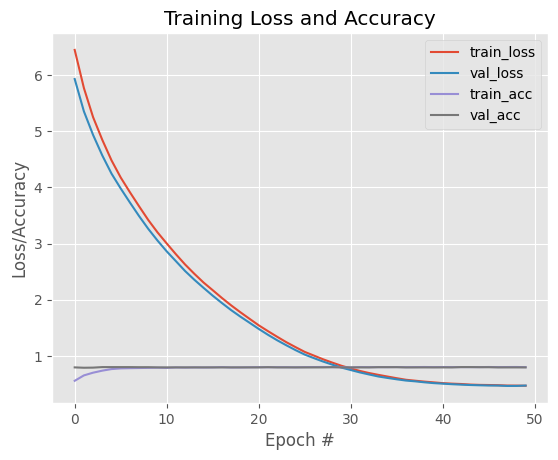

In [ ]:
act = tf.nn.leaky_relu
learning_rate = 0.0002
num_epochs = 50
batch_size  = 256
train_deep_net(act, learning_rate, batch_size, num_epochs)

## Modelo tabular clasificador binario.  
#### Aplicando Ajuste de pesos de clase (class_weight).

In [ ]:
# definimos la función para entrenar nuestra red con los parámetros deseados
def train_deep_net(activation_function, learning_rate, batch_size, num_epochs):


  # Implementamos la red empleando Keras

  dropout_rates = [0.50, 0.40, 0.30, 0.20]

  input_dim = x_tr_encoded.shape[1]


  model = Sequential()
  model.add(Input(shape=(input_dim,)))  # Capa Input explícita
  model.add(Dense(512, activation=activation_function, kernel_regularizer=l2(0.02)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(256, activation=activation_function, kernel_regularizer=l2(0.02)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(128, activation=activation_function, kernel_regularizer=l2(0.02)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(128, activation=activation_function, kernel_regularizer=l2(0.02)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(64, activation=activation_function, kernel_regularizer=l2(0.02)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rates[2]))
  model.add(Dense(2, activation='softmax'))  # Capa de salida con 7 neuronas y activación softmax

  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 10, restore_best_weights=True
  )

  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  #tf.keras.optimizers.Adam(learning_rate=learning_rate)
  #tf.keras.optimizers.SGD(learning_rate=learning_rate)
  lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5)
  opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  model.compile(loss= "binary_crossentropy" , optimizer=opt, metrics=["accuracy"])  #(X)


  class_weights = compute_class_weight("balanced", classes=np.unique(y_tr), y=y_tr)
  class_weight_dict = {i: w for i, w in enumerate(class_weights)}


  # Entrenando la solución
  H = model.fit(x_tr_encoded, y_train_onehot, validation_data=(x_val_encoded, y_val_onehot), epochs=num_epochs, class_weight=class_weight_dict, callbacks=[early_stopping, lr_scheduler])  #(X)

  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x_val_encoded, batch_size=batch_size)
  #print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
  print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

  class_labels = ['Cancer', 'Lesion benigna']
  full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= x_val_encoded,
        y_val= y_val_onehot,
        model_name= "Modelo tabular clasificador binario haciendo uso de class_weight",
        class_labels = class_labels
    )

  # Ver y guardar
  print(full_df.head())
  full_df.to_csv("binary_class_weight_model_metrics.csv", index=False)


  # Guardar la arquitectura del modelo
  model_json = model.to_json()
  with open("binary_class_weight_model_architecture.json", "w") as json_file:
      json_file.write(model_json)

    # Guardar los pesos del modelo
  model.save_weights("binary_class_weight_model.weights.h5")

    # Guardar los resultados en un DataFrame
  history_df = pd.DataFrame(H.history)
  history_df.to_csv("binary_class_weight_model_history.csv", index=False)

  # Muestro gráfica de accuracy y lossen

  plt.style.use("ggplot")
  epochs = len(H.history["loss"])
  plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()


[INFO]: Entrenando red neuronal...
Epoch 1/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5486 - loss: 15.4108 - val_accuracy: 0.6195 - val_loss: 14.0028 - learning_rate: 1.0000e-04
Epoch 2/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5963 - loss: 13.7193 - val_accuracy: 0.6992 - val_loss: 12.5167 - learning_rate: 1.0000e-04
Epoch 3/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6068 - loss: 12.2609 - val_accuracy: 0.6370 - val_loss: 11.2285 - learning_rate: 1.0000e-04
Epoch 4/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6142 - loss: 11.0226 - val_accuracy: 0.6941 - val_loss: 10.1032 - learning_rate: 1.0000e-04
Epoch 5/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6322 - loss: 9.9015 - val_accuracy: 0.6941 - val_loss: 9.0954 - learning_rate: 1.0000e-04
Epoch 6/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6247 - loss: 8.9189 - val_accuracy: 0.6370 - val_loss: 8.1986 - learning_rate: 1.0000e-04
Epoch 7/50
244/244 

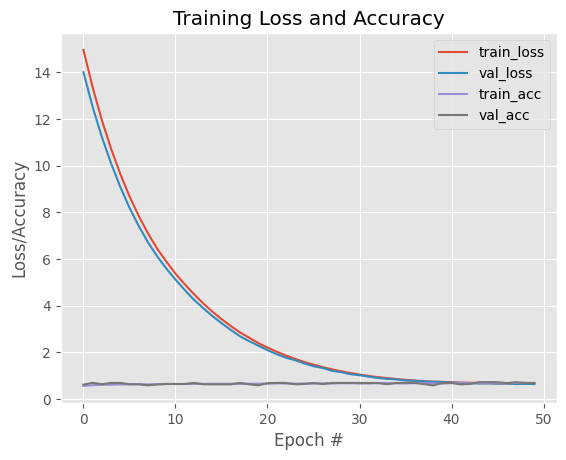

In [ ]:
act = tf.nn.relu
learning_rate = 0.0001
num_epochs = 50
batch_size  = 256
train_deep_net(act, learning_rate, batch_size, num_epochs)

 ## Proceso de selección del Modelo

### Primero cramos una lista con los archivos que contienen las metricas de cada uno de los modelos.  


Al existir diferencias de clases en los dos modelos he de crear un data frame para los modelos de siete clases y otro para el de dos clases.

In [ ]:
multiclass_classification_model_metrics = ['multiclass_embedding_model_metrics.csv', 'multiclass_model_onehot_metrics.csv', 'multiclass_model_onehot_class_weight_metrics.csv']
binary_classification_model_metrics = ['binary_model_metrics.csv', 'binary_class_weight_model_metrics.csv']

#### A continuación se muestran los resultados de los modelos multiclass y binary.

# Dataframe con los resultado de cada uno de los modelos de clasificación multiclase

In [ ]:
multiclass_classification_model_metrics_df = pd.concat([pd.read_csv(f) for f in multiclass_classification_model_metrics], ignore_index=True)

In [ ]:
multiclass_classification_model_metrics_df

accuracy      loss  val_accuracy  val_loss  learning_rate                                                                                                model  akiec_precision  akiec_recall  akiec_f1-score  akiec_support  bcc_precision  bcc_recall  bcc_f1-score  bcc_support  bkl_precision  bkl_recall  bkl_f1-score  bkl_support  df_precision  df_recall  df_f1-score  df_support  mel_precision  mel_recall  mel_f1-score  mel_support  nv_precision  nv_recall  nv_f1-score  nv_support  vasc_precision  vasc_recall  vasc_f1-score  vasc_support  macro avg_precision  macro avg_recall  macro avg_f1-score  macro avg_support  weighted avg_precision  weighted avg_recall  weighted avg_f1-score  weighted avg_support  epoch
0  0.675665  1.066214      0.674036  1.053975         0.0005                           Modelo tabular clasificador multiclase 7 clases haciendo uso de embeddings         0.000000      0.000000        0.000000           78.0       0.000000    0.000000      0.000000         98.0       0.400000    0.215247      0.279883        223.0      0.000000   0.000000     0.000000        26.0            0.0         0.0           0.0        223.0      0.692055   0.994488     0.816155      1270.0        0.000000     0.000000       0.000000          27.0             0.156008          0.172819            0.156577             1945.0                0.497743             0.674036               0.565003                1945.0    NaN
1  0.687918  1.027479      0.687918  1.002255            NaN  Modelo tabular clasificador multiclase 7 clases codificando las variables categóricas con OneHot...         0.000000      0.000000        0.000000           65.0       0.000000    0.000000      0.000000        102.0       0.396825    0.350467      0.372208        214.0      0.000000   0.000000     0.000000        23.0            0.0         0.0           0.0        220.0      0.719248   0.976798     0.828468      1293.0        0.000000     0.000000       0.000000          28.0             0.159439          0.189609            0.171525             1945.0                0.521804             0.687918               0.591703                1945.0   49.0
2  0.390746  1.747901      0.369666  1.720972            NaN        Modelo tabular clasificador multiclase 7 clases  haciendo uso de OneHotEncoder y class_weight         0.129032      0.430769        0.198582           65.0       0.145038    0.372549      0.208791        102.0       0.000000    0.000000      0.000000        214.0      0.033898   0.869565     0.065253        23.0            0.0         0.0           0.0        220.0      0.840200   0.520495     0.642789      1293.0        0.013333     0.035714       0.019417          28.0             0.165929          0.318442            0.162119             1945.0                0.571060             0.390746               0.445951                1945.0   49.0

En el caso de los Modelos tabulares multiclase, seleccionaría El modelo multiclase con class_weight ya que es el único que detecta clases raras como 'akiec' (F1=0.199), 'bcc' (F1=0.209) y 'df' (F1=0.065), algo que los otros modelos ignoraban (F1=0).  

Aunque su precisión general es baja (37%), sacrifica rendimiento en la clase mayoritaria ('nv', F1=0.643) para no pasar por alto casos clínicamente graves, lo que es crucial en diagnóstico médico.  

Resulta más útil para detectar casos aunque como trade-off de aumentar falsos positivos.

# Dataframe con los resultado de cada uno de los modelos de clasificación binaria

In [ ]:
binary_classification_model_metrics_df = pd.concat([pd.read_csv(f) for f in binary_classification_model_metrics], ignore_index=True)

In [ ]:
binary_classification_model_metrics_df

loss  accuracy  val_loss  val_accuracy  epoch                                                             model  Cancer_precision  Cancer_recall  Cancer_f1-score  Cancer_support  Lesion benigna_precision  Lesion benigna_recall  Lesion benigna_f1-score  Lesion benigna_support  macro avg_precision  macro avg_recall  macro avg_f1-score  macro avg_support  weighted avg_precision  weighted avg_recall  weighted avg_f1-score  weighted avg_support
0  0.461934  0.798458  0.459704      0.798458     49                               Modelo tabular clasificador binario          0.545455       0.105263         0.176471           399.0                  0.808887               0.977361                 0.885179                  1546.0             0.677171          0.541312            0.530825             1945.0                0.754846             0.798458               0.739793                1945.0
1  0.677525  0.588175  0.673319      0.588175     49  Modelo tabular clasificador binario haciendo uso de class_weight          0.310377       0.824561         0.450994           399.0                  0.920904               0.527167                 0.670506                  1546.0             0.615641          0.675864            0.560750             1945.0                0.795660             0.588175               0.625475                1945.0

El modelo binario con class_weight es la mejor opción para diagnóstico médico porque, aunque no es perfecto, prioriza lo más importante: detectar cánceres.

Mientras el modelo sin ajustes solo capturaba el 10.5% de los casos malignos (una cifra peligrosamente baja), este detecta el 82.5%, reduciendo el riesgo de pasar por alto lesiones graves. Es cierto que su precisión global baja (58.8%), pero eso se debe a que prefiere equivocarse por exceso (falsos positivos) antes que por defecto (falsos negativos). En medicina, es mejor estudiar de más a un paciente sano que ignorar a uno enfermo.

El F1-score para cáncer (45.1%) es el más alto de todos los modelos analizados, lo que confirma su utilidad práctica. No es el más preciso, pero sí el más seguro.

## Elección del mejor módelo tabular.  

El modelo multiclase, aunque identifica tipos específicos de lesiones, falla estrepitosamente en clases críticas como melanoma (F1=0), un riesgo inaceptable en diagnóstico médico. Prefiero un sistema que sobrediagnostique (aumento de falsos positivos) antes que uno que ignore peligros. El binario prioriza lo esencial: alertar de todo lo potencialmente maligno, aunque luego requiera pruebas complementarias. Es la opción ética y práctica.

# Modelos de imagen CNN

Descargamos el dataset.

In [ ]:
ls /content/drive/MyDrive/practica/data/hnmist_28_28_RGB.csv

/content/drive/MyDrive/practica/data/hnmist_28_28_RGB.csv


In [ ]:
ruta_rgb = '/content/drive/MyDrive/practica/data/hnmist_28_28_RGB.csv'

In [ ]:
rgb_data = pd.read_csv(ruta_rgb)
rgb_data.head(5)

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  pixel0006  pixel0007  pixel0008  pixel0009  pixel0010  pixel0011  pixel0012  pixel0013  pixel0014  pixel0015  pixel0016  pixel0017  pixel0018  pixel0019  pixel0020  pixel0021  pixel0022  pixel0023  pixel0024  pixel0025  pixel0026  pixel0027  pixel0028  pixel0029  pixel0030  pixel0031  pixel0032  pixel0033  pixel0034  pixel0035  pixel0036  pixel0037  pixel0038  pixel0039  pixel0040  pixel0041  pixel0042  pixel0043  pixel0044  pixel0045  pixel0046  pixel0047  pixel0048  pixel0049  pixel0050  pixel0051  pixel0052  pixel0053  pixel0054  pixel0055  pixel0056  pixel0057  pixel0058  pixel0059  pixel0060  pixel0061  pixel0062  pixel0063  pixel0064  pixel0065  pixel0066  pixel0067  pixel0068  pixel0069  pixel0070  pixel0071  pixel0072  pixel0073  pixel0074  pixel0075  pixel0076  pixel0077  pixel0078  pixel0079  pixel0080  pixel0081  pixel0082  pixel0083  pixel0084  pixel0085  pixel0086  pixel0087  pixel0088  pixel0089  \
0        192        153        193        195        155        192        197        154        185        202        162        192        208        165        201        209        165        205        208        165        194        212        169        198        216        181        204        216        178        204        215        172        205        217        173        209        217        166        202        214        161        202        217        171        207        218        172        205        215        164        193        211        163        189        204        154        176        204        153        181        206        161        196        192        138        158        189        133        150        191        139        163        187        134        151        193        144        153        197        154        163        194        152        160        197        162        202        201        160        197   
1         25         14         30         68         48         75        123         93        126        158        128        158        172        136        162        175        134        157        177        126        158        186        138        163        197        153        187        198        153        186        203        168        206        205        169        204        207        164        199        205        162        200        206        166        185        209        163        189        208        165        190        203        156        183        198        150        176        201        153        186        201        153        188        200        152        194        190        144        172        180        135        149        154        114        115        123         92         99         79         53         74         59         37         62         42         28         49         97         70         97   
2        192        138        153        200        145        163        201        142        160        206        149        165        207        149        159        209        156        164        202        136        130        200        133        129        208        146        157        212        159        167        214        157        168        211        143        150        215        148        169        213        150        176        203        138        150        194        121        124        195        122        125        189        114        118        198        132        154        204        148        174        205        149        176        205        153        180        201        146        169        194        140        157        186        133        147        181        131        145        167        123        142        143        102        118        199        146        161        201        145        166   
3         38         19

Comprobamos las dimensiones del dataset.

In [ ]:
print(rgb_data.shape)

(10015, 2352)


2352 columnas se refieren a los pixeles de la imagen y los tres canales de color (R, G, B) de cada pixel.  
No contamos con una variable ***label***

In [ ]:
nombre_ultima_columna = rgb_data.columns[-1]
print(nombre_ultima_columna)

pixel2351


Descargo el dataset que contine la etiqueta del target ***dx***.

In [ ]:
tabular_data  = pd.read_csv(ruta_tabular)

Compruebo que sendos datasets tienen la misma longitud.

In [ ]:
print(tabular_data.shape)

(10015, 8)


Dado que en el ejercicio anterior se eliminaron una serie de filas, y más tarde vamos a fusionar sendos modelos, he de eliminar las mismas filas en el dataset ***rgb_data***.

In [ ]:
# Filtrar filas con NaNs, 0 o 'unknown'
indices_filas = tabular_data[
    tabular_data.isna().any(axis=1) |       # Filas con NaN
    (tabular_data == 0).any(axis=1) |       # Filas con algún 0
    (tabular_data == 'unknown').any(axis=1) # Filas con 'unknown'
].index

# Convertir a lista si es necesario
indices_filas = list(indices_filas)

Útilizo la lista de índices para eliminar las filas correspondientes en ambos DataFrames.  
Después de eliminar filas, es buena práctica resetear los índices, esto evita que queden huecos en los índices originales.

In [ ]:
# Utilizo drop para eliminar las filas con los índices especificados y reset_index para reordenar los índices primero en el tabular_data dtaset.

tabular_data.drop(indices_filas, inplace=True)
tabular_data.reset_index(drop=True, inplace=True)

# A continuación elimino las filas en el rgb_data dataset.

rgb_data.drop(indices_filas, inplace=True)
rgb_data.reset_index(drop=True, inplace=True)

Agrego la columna de la etiqueta al dataset de las imagenes.

In [ ]:
rgb_data['label'] = tabular_data['dx']

Preparo los datos para el entrenamiento.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Separo de los datos la variable target
X = rgb_data.drop(columns=['label']).values
y = rgb_data['label'].values

# Divido los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir etiquetas a enteros
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_tr)
y_val_encoded = label_encoder.transform(y_val)
print(label_encoder.classes_)

# One-Hot para la variable objetivo (si es necesario)
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes=num_classes)

### Normalización de los datos

# Instanciar el normalizador
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustar SOLO con los datos de entrenamiento y transformar
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar la misma transformación a los datos de prueba
X_val_scaled = scaler.transform(X_val)

# Reestructuro el formato de los datos, permitiendo que cada imagen se represente correctamente en su forma original.
X_train_scaled = np.array(X_train_scaled).reshape(-1, 28, 28, 3)
X_val_scaled = np.array(X_val_scaled).reshape(-1, 28, 28, 3)


['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [ ]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, EfficientNetB4, Xception, MobileNetV2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

# Transfer Learning Modelo VGG16

#### Primero cargamos nuestro dataset y lo redimensionamos a las dimensiones mínimas

In [ ]:
# permitidas por la VGG16 -> (48, 48, 3)

input_shape = (48, 48, 3)


# resize train set
X_train_resized = []
for img in X_train_scaled:
  X_train_resized.append(np.resize(img, input_shape))

X_train_resized = np.array(X_train_resized)
print(X_train_resized.shape)

# resize test set
X_val_resized = []
for img in X_val_scaled:
  X_val_resized.append(np.resize(img, input_shape))

X_val_resized = np.array(X_val_resized)
print(X_val_resized.shape)

(7779, 48, 48, 3)
(1945, 48, 48, 3)


#### Creamos el modelo base

In [ ]:
# creamos el modelo base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### Congelamos todas las capas de nuestro base_model para que no se entrenen

In [ ]:
# congelamos todas las capas de nuestro base_model para que no se entrenen
# queremos que nuestro feature extractor siga igual que antes => transfer learning
for layer in base_model.layers:
  layer.trainable = False

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1024, activation='relu', name='our-fc1')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax', name='our-preds')(x)
model = Model(base_model.input, x)

learning_rate = 0.0005
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# vemos la nueva estructura del modelo
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ our-fc1 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,247,175 (58.16 MB)

 Trainable params: 532,487 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Entrenamos el modelo

In [ ]:
# comenzamos con el entrenamiento

epochs = 50
batch_size = 256
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 10, restore_best_weights=True
  )
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5)

callbacks=[early_stopping, lr_scheduler]

# como entrenariamos normalmente
H = model.fit(X_train_resized, y_train_onehot,
          batch_size=batch_size,
          validation_data=(X_val_resized, y_val_onehot),
          epochs=epochs, callbacks=[early_stopping, lr_scheduler])

print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_val_resized, batch_size=batch_size)
#print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))
full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= X_val_resized,
        y_val= y_val_onehot,
        model_name= "VGG16_freezed_model"
    )

  # Ver y guardar
print(full_df.head())
full_df.to_csv("VGG16_freezed_model_metrics.csv", index=False)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.5231 - loss: 1.4622 - val_accuracy: 0.6571 - val_loss: 1.0259 - learning_rate: 5.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6571 - loss: 1.0323 - val_accuracy: 0.6566 - val_loss: 0.9957 - learning_rate: 5.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6758 - loss: 0.9752 - val_accuracy: 0.6643 - val_loss: 0.9715 - learning_rate: 5.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6680 - loss: 0.9859 - val_accuracy: 0.6663 - val_loss: 0.9585 - learning_rate: 5.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6775 - loss: 0.9500 - val_accuracy: 0.6735 - val_loss: 0.9452 - learning_rate: 5.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6776 - loss: 0.9327 - val_accuracy: 0.6725 - val_loss: 0.9400 - learning_rate: 5.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6817

#### Guardamos arquitectura, pesos y resultados del modelo

In [ ]:
# Guardar la arquitectura del modelo
model_json = model.to_json()
with open("VGG16_freeze.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
model.save_weights("VGG16_freeze.weights.h5")

#### Permitimos que, además de la etapa de clasificación, se entrenen también el último bloque convolucional

In [ ]:

for layer in base_model.layers:
  layer.trainable = False
  if 'block5' in layer.name:
    layer.trainable = True

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1024, activation='relu', name='our-fc1')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax', name='our-preds')(x)
model = Model(base_model.input, x)

learning_rate = 0.0005
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# vemos la nueva estructura del modelo
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ our-fc1 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,247,175 (58.16 MB)

 Trainable params: 7,611,911 (29.04 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

#### Entrenamos el modelo

In [ ]:
# comenzamos con el entrenamiento

epochs = 50
batch_size = 256
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 10, restore_best_weights=True
  )
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5)

callbacks=[early_stopping, lr_scheduler]

# como entrenariamos normalmente
H = model.fit(X_train_resized, y_train_onehot,
          batch_size=batch_size,
          validation_data=(X_val_resized, y_val_onehot),
          epochs=epochs, callbacks=[early_stopping, lr_scheduler])

print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_val_resized, batch_size=batch_size)
#print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= X_val_resized,
        y_val= y_val_onehot,
        model_name= "VGG16_last_block_training_model"
    )

  # Ver y guardar
print(full_df.head())
full_df.to_csv("VGG16_last_block_training_model_metrics.csv", index=False)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.5769 - loss: 1.3474 - val_accuracy: 0.6560 - val_loss: 0.9960 - learning_rate: 5.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6647 - loss: 0.9835 - val_accuracy: 0.6771 - val_loss: 0.9291 - learning_rate: 5.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6762 - loss: 0.9191 - val_accuracy: 0.6638 - val_loss: 0.9523 - learning_rate: 5.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6818 - loss: 0.8887 - val_accuracy: 0.6925 - val_loss: 0.8827 - learning_rate: 5.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6837 - loss: 0.8825 - val_accuracy: 0.6951 - val_loss: 0.8682 - learning_rate: 5.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6956 - loss: 0.8362 - val_accuracy: 0.6956 - val_loss: 0.8583 - learning_rate: 5.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7000

#### Guardamos arquitectura, pesos y resultados del modelo

In [ ]:
# Guardar la arquitectura del modelo
model_json = model.to_json()
with open("VGG16_last_block_training.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
model.save_weights("VGG16_last_block_training.weights.h5")

# Guardar los resultados en un DataFrame
history_df = pd.DataFrame(H.history)
history_df.to_csv("VGG16_last_block_training.csv", index=False)

#### Permitimos que, además de la etapa de clasificación, se entrenen también el/los bloques que aparecen en la lista.

In [ ]:
# Lista de bloques que quieres hacer trainable
trainable_blocks = [ 'block4', 'block5']

# Marcar como trainable las capas que pertenezcan a esos bloques
for layer in base_model.layers:
    if any(block in layer.name for block in trainable_blocks):
        layer.trainable = True
    else:
        layer.trainable = False

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1024, activation='relu', name='our-fc1')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax', name='our-preds')(x)
model = Model(base_model.input, x)

learning_rate = 0.0005
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# vemos la nueva estructura del modelo
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ our-fc1 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,247,175 (58.16 MB)

 Trainable params: 13,511,687 (51.54 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

#### Entrenamos el modelo

In [ ]:
# comenzamos con el entrenamiento

epochs = 50
batch_size = 256
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 10, restore_best_weights=True
  )
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5)

callbacks=[early_stopping, lr_scheduler]

# como entrenariamos normalmente
H = model.fit(X_train_resized, y_train_onehot,
          batch_size=batch_size,
          validation_data=(X_val_resized, y_val_onehot),
          epochs=epochs, callbacks=[early_stopping, lr_scheduler])

print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_val_resized, batch_size=batch_size)
#print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= X_val_resized,
        y_val= y_val_onehot,
        model_name= "VGG16_2_last_blocks_training_model"
    )

  # Ver y guardar
print(full_df.head())
full_df.to_csv("VGG16_2_last_blocks_training_model_metrics.csv", index=False)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.5873 - loss: 1.4870 - val_accuracy: 0.6530 - val_loss: 1.1381 - learning_rate: 5.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6652 - loss: 1.0602 - val_accuracy: 0.6560 - val_loss: 0.9891 - learning_rate: 5.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6744 - loss: 0.9431 - val_accuracy: 0.6684 - val_loss: 0.9419 - learning_rate: 5.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6772 - loss: 0.9347 - val_accuracy: 0.6653 - val_loss: 1.0126 - learning_rate: 5.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6797 - loss: 0.9360 - val_accuracy: 0.6776 - val_loss: 0.8928 - learning_rate: 5.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6757 - loss: 0.9051 - val_accuracy: 0.6838 - val_loss: 0.8802 - learning_rate: 5.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.683

#### Guardamos arquitectura, pesos y resultados del modelo

In [ ]:
# Guardar la arquitectura del modelo
model_json = model.to_json()
with open("VGG16_2_last_blocks_training.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
model.save_weights("VGG16_2_last_blocks_training.weights.h5")

#### Permitimos que, además de la etapa de clasificación, se entrenen también el/los bloques que aparecen en la lista.

In [ ]:
# permitimos que, además de la etapa de clasificación, se entrenen también el/los
# bloques que aparecen en la lista.
# Lista de bloques que quieres hacer trainable
trainable_blocks = ['block3', 'block4', 'block5']

for layer in base_model.layers:
    if any(block in layer.name for block in trainable_blocks):
        layer.trainable = True
    else:
        layer.trainable = False

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1024, activation='relu', name='our-fc1')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax', name='our-preds')(x)
model = Model(base_model.input, x)

learning_rate = 0.0005
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# vemos la nueva estructura del modelo
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ our-fc1 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,247,175 (58.16 MB)

 Trainable params: 14,987,015 (57.17 MB)

 Non-trainable params: 260,160 (1016.25 KB)

#### Entrenamos el modelo

In [ ]:
# comenzamos con el entrenamiento

epochs = 50
batch_size = 256
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 10, restore_best_weights=True
  )
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.6, patience=5)

callbacks=[early_stopping, lr_scheduler]

# como entrenariamos normalmente
H = model.fit(X_train_resized, y_train_onehot,
          batch_size=batch_size,
          validation_data=(X_val_resized, y_val_onehot),
          epochs=epochs, callbacks=[early_stopping, lr_scheduler])

print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_val_resized, batch_size=batch_size)
#print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= X_val_resized,
        y_val= y_val_onehot,
        model_name= "VGG16_3_last_blocks_training_model"
    )

  # Ver y guardar
print(full_df.head())
full_df.to_csv("VGG16_3_last_blocks_training_metrics.csv", index=False)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - accuracy: 0.5512 - loss: 2.0009 - val_accuracy: 0.6530 - val_loss: 1.1466 - learning_rate: 5.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6691 - loss: 1.0744 - val_accuracy: 0.6530 - val_loss: 1.0050 - learning_rate: 5.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6688 - loss: 0.9899 - val_accuracy: 0.6638 - val_loss: 0.9642 - learning_rate: 5.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6729 - loss: 0.9601 - val_accuracy: 0.6596 - val_loss: 0.9513 - learning_rate: 5.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6638 - loss: 0.9338 - val_accuracy: 0.6560 - val_loss: 0.9300 - learning_rate: 5.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6716 - loss: 0.9092 - val_accuracy: 0.6843 - val_loss: 0.9289 - learning_rate: 5.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.682

#### Guardamos arquitectura, pesos y resultados del modelo

In [ ]:
# Guardar la arquitectura del modelo
model_json = model.to_json()
with open("VGG16_3_last_blocks_training.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
model.save_weights("VGG16_3_last_blocks_training.weights.h5")

# Transfer Learning Modelo EfficientNetB4

#### Primero cargamos nuestro dataset y lo redimensionamos a las dimensiones mínimas

In [ ]:
input_shape = (224, 224, 3)


# resize train set
X_train_resized = []
for img in X_train_scaled:
  X_train_resized.append(np.resize(img, input_shape))

X_train_resized = np.array(X_train_resized)
print(X_train_resized.shape)

# resize test set
X_val_resized = []
for img in X_val_scaled:
  X_val_resized.append(np.resize(img, input_shape))

X_val_resized = np.array(X_val_resized)
print(X_val_resized.shape)

(7779, 224, 224, 3)
(1945, 224, 224, 3)


#### creamos el modelo base

In [ ]:

base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 17,548,616 (66.94 MB)

 Non-trainable params: 125,207 (489.09 KB)

#### Congelamos todas las capas de nuestro base_model para que no se entrenen

In [ ]:

for layer in base_model.layers:
  layer.trainable = False


# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1024, activation='relu', name='our-fc1')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax', name='our-preds')(x)
model = Model(base_model.input, x)

learning_rate = 0.0005
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# vemos la nueva estructura del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 107,597,414 (410.45 MB)

 Trainable params: 89,923,591 (343.03 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

#### Entrenamos el modelo

In [ ]:
# comenzamos con el entrenamiento

epochs = 50
batch_size = 256
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 10, restore_best_weights=True
  )
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5)

callbacks=[early_stopping, lr_scheduler]

# como entrenariamos normalmente
H = model.fit(X_train_resized, y_train_onehot,
          batch_size=batch_size,
          validation_data=(X_val_resized, y_val_onehot),
          epochs=epochs, callbacks=[early_stopping, lr_scheduler])

print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_val_resized, batch_size=batch_size)
#print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= X_val_resized,
        y_val= y_val_onehot,
        model_name= "EfficientNetB4_freeze_model"
    )

  # Ver y guardar
print(full_df.head())
full_df.to_csv("EfficientNetB4_freeze_model_metrics.csv", index=False)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.6642 - loss: 1.2256 - val_accuracy: 0.6530 - val_loss: 1.1837 - learning_rate: 3.2000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.6675 - loss: 1.2828 - val_accuracy: 0.6530 - val_loss: 1.1726 - learning_rate: 3.2000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.6566 - loss: 1.2644 - val_accuracy: 0.6530 - val_loss: 1.1783 - learning_rate: 3.2000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.6678 - loss: 1.2359 - val_accuracy: 0.6530 - val_loss: 1.1724 - learning_rate: 3.2000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.6704 - loss: 1.2324 - val_accuracy: 0.6530 - val_loss: 1.1723 - learning_rate: 3.2000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.6607 - loss: 1.2359 - val_accuracy: 0.6530 - val_loss: 1.1724 - learning_rate: 3.2000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 

#### Guardamos arquitectura, pesos y resultados del modelo

In [ ]:
# Guardar la arquitectura del modelo
model_json = model.to_json()
with open("EfficientNetB4_freeze.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
model.save_weights("EfficientNetB4_freeze.weights.h5")

#### Permitimos que, además de la etapa de clasificación, se entrenen también el último bloque convolucional.

In [ ]:
# permitimos que, además de la etapa de clasificación, se entrenen también el
# último bloque convolucional
# Lista de bloques que quieres hacer trainable
trainable_blocks = ['block7']
for layer in base_model.layers:
    # Verifica si el nombre de la capa comienza con alguno de los bloques
    if any(layer.name.startswith(block) for block in trainable_blocks):
        layer.trainable = True
    else:
        layer.trainable = False

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(512, activation='relu', name='our-fc1')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax', name='our-preds')(x)
model = Model(base_model.input, x)

learning_rate = 0.0005
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])

# vemos la nueva estructura del modelo
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 62,635,622 (238.94 MB)

 Trainable params: 49,431,803 (188.57 MB)

 Non-trainable params: 13,203,819 (50.37 MB)

#### Entrenamos el modelo

In [ ]:
# comenzamos con el entrenamiento

epochs = 50
batch_size = 128
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 10, restore_best_weights=True
  )
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5)

callbacks=[early_stopping, lr_scheduler]

# como entrenariamos normalmente
H = model.fit(X_train_resized, y_train_onehot,
          batch_size=batch_size,
          validation_data=(X_val_resized, y_val_onehot),
          epochs=epochs, callbacks=[early_stopping, lr_scheduler])

print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_val_resized, batch_size=batch_size)
#print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= X_val_resized,
        y_val= y_val_onehot,
        model_name= "EfficientNetB4_last_block_training_model"
    )

  # Ver y guardar
print(full_df.head())
full_df.to_csv("EfficientNetB4_last_block_training_model_metrics.csv", index=False)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.5095 - loss: 6.8180 - val_accuracy: 0.6530 - val_loss: 1.2714 - learning_rate: 5.0000e-04
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.6484 - loss: 1.3036 - val_accuracy: 0.6530 - val_loss: 1.2091 - learning_rate: 5.0000e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.6651 - loss: 1.2873 - val_accuracy: 0.6530 - val_loss: 1.1747 - learning_rate: 5.0000e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.6607 - loss: 1.2576 - val_accuracy: 0.6535 - val_loss: 1.1852 - learning_rate: 5.0000e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.6708 - loss: 1.2217 - val_accuracy: 0.6524 - val_loss: 1.1725 - learning_rate: 5.0000e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.6715 - loss: 1.2296 - val_accuracy: 0.6530 - val_loss: 1.1873 - learning_rate: 5.0000e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0

#### Guardamos arquitectura, pesos y resultados del modelo

In [ ]:
# Guardar la arquitectura del modelo
model_json = model.to_json()
with open("EfficientNetB4_last_block_training.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
model.save_weights("EfficientNetB4_last_block_training.weights.h5")

#### Permitimos que, además de la etapa de clasificación, se entrenen también el/los bloques que aparecen en la lista.

In [ ]:
# Lista de bloques que quieres hacer trainable
trainable_blocks = ['block6','block7']


for layer in base_model.layers:
    # Verifica si el nombre de la capa comienza con alguno de los bloques
    if any(layer.name.startswith(block) for block in trainable_blocks):
        layer.trainable = True
    else:
        layer.trainable = False

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(512, activation='relu', name='our-fc1')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax', name='our-preds')(x)
model = Model(base_model.input, x)

learning_rate = 0.0005
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# vemos la nueva estructura del modelo
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 62,635,622 (238.94 MB)

 Trainable params: 58,068,031 (221.51 MB)

 Non-trainable params: 4,567,591 (17.42 MB)

#### Entrenamos el modelo

In [ ]:
# comenzamos con el entrenamiento

epochs = 50
batch_size = 128
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 10, restore_best_weights=True
  )
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5)

callbacks=[early_stopping, lr_scheduler]

# como entrenariamos normalmente
H = model.fit(X_train_resized, y_train_onehot,
          batch_size=batch_size,
          validation_data=(X_val_resized, y_val_onehot),
          epochs=epochs, callbacks=[early_stopping, lr_scheduler])

print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_val_resized, batch_size=batch_size)
#print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= X_val_resized,
        y_val= y_val_onehot,
        model_name= "EfficientNetB4_2_last_blocks_training_model"
    )

  # Ver y guardar
print(full_df.head())
full_df.to_csv("EfficientNetB4_2_last_blocks_training_model_metrics.csv", index=False)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5367 - loss: 3.4115 - val_accuracy: 0.6530 - val_loss: 1.1703 - learning_rate: 5.0000e-04
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6598 - loss: 1.2795 - val_accuracy: 0.6530 - val_loss: 1.2024 - learning_rate: 5.0000e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.6635 - loss: 1.2950 - val_accuracy: 0.6530 - val_loss: 1.1932 - learning_rate: 5.0000e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.6668 - loss: 1.2040 - val_accuracy: 0.6530 - val_loss: 1.2064 - learning_rate: 5.0000e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.6721 - loss: 1.1716 - val_accuracy: 0.6530 - val_loss: 1.2351 - learning_rate: 5.0000e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6665 - loss: 1.1577 - val_accuracy: 0.6530 - val_loss: 1.2929 - learning_rate: 5.0000e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0

In [ ]:
# Guardar la arquitectura del modelo
model_json = model.to_json()
with open("EfficientNetB4_2_last_blocks_training.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
model.save_weights("EfficientNetB4_2_last_blocks_training.weights.h5")

#### Guardamos arquitectura, pesos y resultados del modelo

# Transfer Learning Modelo Xception

#### Primero cargamos nuestro dataset y lo redimensionamos a las dimensiones mínimas

In [ ]:
input_shape = (299, 299, 3)


# resize train set
X_train_resized = []
for img in X_train_scaled:
  X_train_resized.append(np.resize(img, input_shape))

X_train_resized = np.array(X_train_resized)
print(X_train_resized.shape)

# resize test set
X_val_resized = []
for img in X_val_scaled:
  X_val_resized.append(np.resize(img, input_shape))

X_val_resized = np.array(X_val_resized)
print(X_val_resized.shape)

(7779, 299, 299, 3)
(1945, 299, 299, 3)


#### Creamos el modelo base

In [ ]:

base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

#### Congelamos todas las capas de nuestro base_model para que no se entrenen

In [ ]:

for layer in base_model.layers:
  layer.trainable = False

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = GlobalAveragePooling2D()(last)
x = Dense(512, activation='relu', name='our-fc1')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax', name='our-preds')(x)
model = Model(base_model.input, x)

learning_rate = 0.0005
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# vemos la nueva estructura del modelo
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,914,159 (83.60 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

#### Entrenamos el modelo

In [ ]:
# comenzamos con el entrenamiento

epochs = 50
batch_size = 64
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 5, restore_best_weights=True
  )
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5)

callbacks=[early_stopping, lr_scheduler]

# como entrenariamos normalmente
H = model.fit(X_train_resized, y_train_onehot,
          batch_size=batch_size,
          validation_data=(X_val_resized, y_val_onehot),
          epochs=epochs, callbacks=[early_stopping, lr_scheduler])

print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_val_resized, batch_size=batch_size)
#print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 74s 490ms/step - accuracy: 0.6388 - loss: 1.1308 - val_accuracy: 0.6715 - val_loss: 0.9506 - learning_rate: 5.0000e-04
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.6858 - loss: 0.9208 - val_accuracy: 0.6802 - val_loss: 0.9195 - learning_rate: 5.0000e-04
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.6818 - loss: 0.9170 - val_accuracy: 0.6663 - val_loss: 0.9147 - learning_rate: 5.0000e-04
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.6920 - loss: 0.8862 - val_accuracy: 0.6807 - val_loss: 0.9090 - learning_rate: 5.0000e-04
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.6884 - loss: 0.8682 - val_accuracy: 0.6787 - val_loss: 0.8983 - learning_rate: 5.0000e-04
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.6906 - loss: 0.8578 - val_accuracy: 0.6699 - val_loss: 0.9130 - learning_rate: 5.0000e-04
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - a

#### Guardamos arquitectura, pesos y resultados del modelo

In [ ]:
# Guardar la arquitectura del modelo
model_json = model.to_json()
with open("Xception_freeze.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
model.save_weights("Xception_freeze.weights.h5")

# Guardar los resultados en un DataFrame

full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= X_val_resized,
        y_val= y_val_onehot,
        model_name= "Xception_freeze_model"
    )

  # Ver y guardar
print(full_df.head())
full_df.to_csv("Xception_freeze_model_metrics.csv", index=False)

       loss  accuracy  val_loss  val_accuracy  epoch                  model  0_precision  0_recall  0_f1-score  0_support  1_precision  1_recall  1_f1-score  1_support  2_precision  2_recall  2_f1-score  2_support  3_precision  3_recall  3_f1-score  3_support  4_precision  4_recall  4_f1-score  4_support  5_precision  5_recall  5_f1-score  5_support  6_precision  6_recall  6_f1-score  6_support  macro avg_precision  macro avg_recall  macro avg_f1-score  macro avg_support  weighted avg_precision  weighted avg_recall  weighted avg_f1-score  weighted avg_support
0  0.730296  0.703856  0.853446      0.695116     22  Xception_freeze_model     0.309091  0.217949    0.255639       78.0     0.372549  0.193878    0.255034       98.0     0.421622  0.349776    0.382353      223.0          0.0       0.0         0.0       26.0     0.484615  0.282511    0.356941      223.0     0.782009  0.937795    0.852846     1270.0          1.0  0.037037    0.071429       27.0             0.481412          0.2884

Permitimos que, además de la etapa de clasificación, se entrenen también el/los bloques que aparecen en la lista.

In [ ]:

# Lista de bloques que quieres hacer trainable
trainable_blocks = ['block12','block13', 'block14']

for layer in base_model.layers:
    # Verifica si el nombre de la capa comienza con alguno de los bloques
    if any(layer.name.startswith(block) for block in trainable_blocks):
        layer.trainable = True
    else:
        layer.trainable = False

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(512, activation='relu', name='our-fc1')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax', name='our-preds')(x)
model = Model(base_model.input, x)

learning_rate = 0.0005
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# vemos la nueva estructura del modelo
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 125,723,183 (479.60 MB)

 Trainable params: 112,516,543 (429.22 MB)

 Non-trainable params: 13,206,640 (50.38 MB)

Entrenamos el modelo.

In [ ]:
# comenzamos con el entrenamiento

epochs = 50
batch_size = 128
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 5, restore_best_weights=True
  )
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5)

callbacks=[early_stopping, lr_scheduler]

# como entrenariamos normalmente
H = model.fit(X_train_resized, y_train_onehot,
          batch_size=batch_size,
          validation_data=(X_val_resized, y_val_onehot),
          epochs=epochs, callbacks=[early_stopping, lr_scheduler])

print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_val_resized, batch_size=batch_size)
#print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))
# Guardar los resultados en un DataFrame

full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= X_val_resized,
        y_val= y_val_onehot,
        model_name= "Xception_3_last_blocks_model"
    )

  # Ver y guardar
print(full_df.head())
full_df.to_csv("Xception_3_last_blocks_model_metrics.csv", index=False)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5985 - loss: 4.0541 - val_accuracy: 0.6530 - val_loss: 1.1564 - learning_rate: 5.0000e-04
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.6779 - loss: 0.9358 - val_accuracy: 0.6771 - val_loss: 0.9227 - learning_rate: 5.0000e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.6747 - loss: 0.9036 - val_accuracy: 0.6699 - val_loss: 0.9265 - learning_rate: 5.0000e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.7004 - loss: 0.8253 - val_accuracy: 0.6787 - val_loss: 0.9365 - learning_rate: 5.0000e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.7148 - loss: 0.7635 - val_accuracy: 0.6931 - val_loss: 0.8589 - learning_rate: 5.0000e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.7366 - loss: 0.6938 - val_accuracy: 0.6931 - val_loss: 0.8348 - learning_rate: 5.0000e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accura

Guardamos arquitectura, pesos y resultados del modelo.

In [ ]:
# Guardar la arquitectura del modelo
model_json = model.to_json()
with open("Xception_3_last_blocks_model-architecture.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
model.save_weights("Xception_3_last_blocks_model.weights.h5")


# Transfer Learning Modelo MobileNetV2

#### Primero cargamos nuestro dataset y lo redimensionamos a las dimensiones mínimas

In [ ]:
input_shape = (224, 224, 3)


# resize train set
X_train_resized = []
for img in X_train_scaled:
  X_train_resized.append(np.resize(img, input_shape))

X_train_resized = np.array(X_train_resized)
print(X_train_resized.shape)

# resize test set
X_val_resized = []
for img in X_val_scaled:
  X_val_resized.append(np.resize(img, input_shape))

X_val_resized = np.array(X_val_resized)
print(X_val_resized.shape)

(7779, 224, 224, 3)
(1945, 224, 224, 3)


#### creamos el modelo base

In [ ]:
# creamos el modelo base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

#### Congelamos todas las capas de nuestro base_model para que no se entrenen

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(512, activation='relu', name='our-fc1')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax', name='our-preds')(x)
model = Model(base_model.input, x)

learning_rate = 0.0005
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# vemos la nueva estructura del modelo
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 34,374,727 (131.13 MB)

 Trainable params: 32,116,743 (122.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Entrenamos el modelo

In [ ]:
# comenzamos con el entrenamiento

epochs = 50
batch_size = 256
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 10, restore_best_weights=True
  )
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5)

callbacks=[early_stopping, lr_scheduler]

# como entrenariamos normalmente
H = model.fit(X_train_resized, y_train_onehot,
          batch_size=batch_size,
          validation_data=(X_val_resized, y_val_onehot),
          epochs=epochs, callbacks=[early_stopping, lr_scheduler])

print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_val_resized, batch_size=batch_size)
#print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5139 - loss: 10.3460 - val_accuracy: 0.6591 - val_loss: 1.0036 - learning_rate: 5.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.6489 - loss: 1.0586 - val_accuracy: 0.6787 - val_loss: 0.9090 - learning_rate: 5.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.6733 - loss: 0.9686 - val_accuracy: 0.6817 - val_loss: 0.8900 - learning_rate: 5.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.6784 - loss: 0.9294 - val_accuracy: 0.6900 - val_loss: 0.8701 - learning_rate: 5.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.6862 - loss: 0.8819 - val_accuracy: 0.6833 - val_loss: 0.8671 - learning_rate: 5.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.6936 - loss: 0.8591 - val_accuracy: 0.6859 - val_loss: 0.8542 - learning_rate: 5.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.7118 

#### Guardamos arquitectura, pesos y resultados del modelo

In [ ]:
# Guardar la arquitectura del modelo
model_json = model.to_json()
with open("MobileNetV2_freeze.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
model.save_weights("MobileNetV2_freeze.weights.h5")

# Guardar los resultados en un DataFrame
full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= X_val_resized,
        y_val= y_val_onehot,
        model_name= "MobileNetV2_freeze_model"
    )

  # Ver y guardar
print(full_df.head())
full_df.to_csv("MobileNetV2_freeze_model_metrics.csv", index=False)

       loss  accuracy  val_loss  val_accuracy  epoch                     model  0_precision  0_recall  0_f1-score  0_support  1_precision  1_recall  1_f1-score  1_support  2_precision  2_recall  2_f1-score  2_support  3_precision  3_recall  3_f1-score  3_support  4_precision  4_recall  4_f1-score  4_support  5_precision  5_recall  5_f1-score  5_support  6_precision  6_recall  6_f1-score  6_support  macro avg_precision  macro avg_recall  macro avg_f1-score  macro avg_support  weighted avg_precision  weighted avg_recall  weighted avg_f1-score  weighted avg_support
0  0.551575  0.699229  0.843512      0.698715     24  MobileNetV2_freeze_model     0.458333  0.141026    0.215686       78.0     0.246377  0.173469    0.203593       98.0     0.448819  0.255605    0.325714      223.0          0.0       0.0         0.0       26.0     0.510204  0.224215    0.311526      223.0     0.752774  0.961417    0.844398     1270.0          0.8  0.148148        0.25       27.0             0.459501          

#### Permitimos que, además de la etapa de clasificación, se entrenen también el/los bloques que aparecen en la lista.

In [ ]:
# Lista de bloques que quieres hacer trainable
trainable_blocks = ['block_12', 'block_13', 'block_14', 'block_15', 'block_16']

# Marcar como trainable las capas que pertenezcan a esos bloques
for layer in base_model.layers:
    if any(block in layer.name for block in trainable_blocks):
        layer.trainable = True
    else:
        layer.trainable = False

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(512, activation='relu', name='our-fc1')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax', name='our-preds')(x)
model = Model(base_model.input, x)

learning_rate = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# vemos la nueva estructura del modelo
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 34,374,727 (131.13 MB)

 Trainable params: 33,504,199 (127.81 MB)

 Non-trainable params: 870,528 (3.32 MB)

#### Entrenamos el modelo

In [ ]:
# comenzamos con el entrenamiento

epochs = 100
batch_size = 128
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 20, restore_best_weights=True
  )
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5)

callbacks=[early_stopping, lr_scheduler]

# como entrenariamos normalmente
H = model.fit(X_train_resized, y_train_onehot,
          batch_size=batch_size,
          validation_data=(X_val_resized, y_val_onehot),
          epochs=epochs, callbacks=[early_stopping, lr_scheduler])

print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_val_resized, batch_size=batch_size)
#print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 46s 377ms/step - accuracy: 0.5682 - loss: 2.5325 - val_accuracy: 0.6530 - val_loss: 1.6427 - learning_rate: 1.0000e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7286 - loss: 0.7612 - val_accuracy: 0.6530 - val_loss: 2.0917 - learning_rate: 1.0000e-04
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7763 - loss: 0.5931 - val_accuracy: 0.6530 - val_loss: 1.9724 - learning_rate: 1.0000e-04
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8468 - loss: 0.4262 - val_accuracy: 0.6530 - val_loss: 2.3637 - learning_rate: 1.0000e-04
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9048 - loss: 0.2890 - val_accuracy: 0.6530 - val_loss: 2.6294 - learning_rate: 1.0000e-04
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9394 - loss: 0.1874 - val_accuracy: 0.6530 - val_loss: 2.5867 - learning_rate: 1.0000e-04
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy

#### Guardamos arquitectura, pesos y resultados del modelo

In [ ]:
# Guardar la arquitectura del modelo
model_json = model.to_json()
with open("MobileNetV2_5_last_blocks_training.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
model.save_weights("MobileNetV2_5_last_blocks_training.weights.h5")

# Guardar los resultados en un DataFrame
full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= X_val_resized,
        y_val= y_val_onehot,
        model_name= "MobileNetV2_5_last_blocks_training_model"
    )

  # Ver y guardar
print(full_df.head())
full_df.to_csv("MobileNetV2_5_last_blocks_training_model_metrics.csv", index=False)

       loss  accuracy  val_loss  val_accuracy  epoch                                     model  0_precision  0_recall  0_f1-score  0_support  1_precision  1_recall  1_f1-score  1_support  2_precision  2_recall  2_f1-score  2_support  3_precision  3_recall  3_f1-score  3_support  4_precision  4_recall  4_f1-score  4_support  5_precision  5_recall  5_f1-score  5_support  6_precision  6_recall  6_f1-score  6_support  macro avg_precision  macro avg_recall  macro avg_f1-score  macro avg_support  weighted avg_precision  weighted avg_recall  weighted avg_f1-score  weighted avg_support
0  0.008186  0.652956  2.522916      0.655527     20  MobileNetV2_5_last_blocks_training_model          0.0       0.0         0.0       78.0          0.0       0.0         0.0       98.0          0.0       0.0         0.0      223.0          0.0       0.0         0.0       26.0          0.0       0.0         0.0      223.0     0.652956       1.0    0.790047     1270.0          0.0       0.0         0.0       27.

# Selección del modelo de imagen CNN

#### Primero cramos una lista con los archivos que contienen las metricas de cada uno de los modelos.

In [ ]:
models_metrics = ['MobileNetV2_5_last_blocks_training_model_metrics.csv', 'MobileNetV2_freeze_model_metrics.csv', 'Xception_3_last_blocks_model_metrics.csv', 'Xception_freeze_model_metrics.csv', 'EfficientNetB4_2_last_blocks_training_model_metrics.csv', 'EfficientNetB4_last_block_training_model_metrics.csv', 'EfficientNetB4_freeze_model_metrics.csv', 'VGG16_3_last_blocks_training_metrics.csv', 'VGG16_2_last_blocks_training_model_metrics.csv', 'VGG16_last_block_training_model_metrics.csv', 'VGG16_freezed_model_metrics.csv']

#### A continuación, creamos un dataframe con los resultado de cada uno de los modelos

In [ ]:
all_model_metrics = pd.concat([pd.read_csv(f) for f in models_metrics], ignore_index=True)

In [ ]:
# Lista de etiquetas originales
labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Diccionario de renombrado
rename_dict = {}
for i, label in enumerate(labels):
    rename_dict.update({
        f'{i}_precision': f'{label}_precision',
        f'{i}_recall': f'{label}_recall',
        f'{i}_f1-score': f'{label}_f1-score',
        f'{i}_support': f'{label}_support'
    })

# Aplicar el cambio
all_model_metrics_renamed = all_model_metrics.rename(columns=rename_dict)


In [ ]:
all_model_metrics_renamed

loss  accuracy  val_loss  val_accuracy  epoch                                        model  akiec_precision  akiec_recall  akiec_f1-score  akiec_support  bcc_precision  bcc_recall  bcc_f1-score  bcc_support  bkl_precision  bkl_recall  bkl_f1-score  bkl_support  df_precision  df_recall  df_f1-score  df_support  mel_precision  mel_recall  mel_f1-score  mel_support  nv_precision  nv_recall  nv_f1-score  nv_support  vasc_precision  vasc_recall  vasc_f1-score  vasc_support  macro avg_precision  macro avg_recall  macro avg_f1-score  macro avg_support  weighted avg_precision  weighted avg_recall  weighted avg_f1-score  weighted avg_support
0   0.008186  0.652956  2.522916      0.655527     20     MobileNetV2_5_last_blocks_training_model         0.000000      0.000000        0.000000           78.0       0.000000    0.000000      0.000000         98.0       0.000000    0.000000      0.000000        223.0           0.0        0.0          0.0        26.0       0.000000    0.000000      0.000000        223.0      0.652956   1.000000     0.790047      1270.0        0.000000     0.000000       0.000000          27.0             0.093279          0.142857            0.112864             1945.0                0.426352             0.652956               0.515866                1945.0
1   0.551575  0.699229  0.843512      0.698715     24                     MobileNetV2_freeze_model         0.458333      0.141026        0.215686           78.0       0.246377    0.173469      0.203593         98.0       0.448819    0.255605      0.325714        223.0           0.0        0.0          0.0        26.0       0.510204    0.224215      0.311526        223.0      0.752774   0.961417     0.844398      1270.0        0.800000     0.148148       0.250000          27.0             0.459501          0.271983            0.307274             1945.0                0.643383             0.699229               0.646795                1945.0
2   0.360389  0.693059  1.294650      0.687404     10                 Xception_3_last_blocks_model         0.769231      0.128205        0.219780           78.0       0.298246    0.346939      0.320755         98.0       0.359813    0.345291      0.352403        223.0           0.0        0.0          0.0        26.0       0.402655    0.408072      0.405345        223.0      0.825547   0.890551     0.856818      1270.0        0.625000     0.185185       0.285714          27.0             0.468642          0.329178            0.348688             1945.0                0.681017             0.693059               0.675284                1945.0
3   0.730296  0.703856  0.853446      0.695116     22                        Xception_freeze_model         0.309091      0.217949        0.255639           78.0       0.372549    0.193878      0.255034         98.0       0.421622    0.349776      0.382353        223.0           0.0        0.0          0.0        26.0       0.484615    0.282511      0.356941        223.0      0.782009   0.937795     0.852846      1270.0        1.000000     0.037037       0.071429          27.0             0.481412          0.288421            0.310606             1945.0                0.659569             0.703856               0.665727                1945.0
4   0.980970  0.652956  1.071984      0.653985     43  EfficientNetB4_2_last_blocks_training_model         0.000000      0.000000        0.000000           78.0       0.000000    0.000000      0.000000         98.0       0.000000    0.000000      0.000000        223.0           0.0        0.0          0.0        26.0       0.000000    0.000000      0.000000        223.0      0.652956   1.000000     0.790047      1270.0        0.000000     0.000000       0.000000          27.0             0.093279          0.142857            0.112864             1945.0                0.426352             0.652956               0.515866                1945.0
5   1.128161  0.652956  1.173266      0.653985     49     EfficientNetB4_last_block_training_model         0.00000

# Elección del mejor modelo desde un punto de vista clínico

El modelo VGG16_3_last_blocks_training_model destaca como la opción más equilibrada para el diagnóstico de lesiones cutáneas. Su valor radica en que, además de lograr una precisión global del 74.2%, es el único que detecta de forma consistente los casos más graves: identifica el 34.5% de los melanomas, el 50% de los carcinomas y el 42.3% de las queratosis actínicas.

Estas cifras cobran especial relevancia al compararlo con otros modelos que simplemente ignoraban estas lesiones peligrosas (mostrando un 0% de detección). Claro que a veces puede generar falsas alarmas -clasificando como malignas algunas lesiones benignas-, pero en el ámbito médico este enfoque conservador es preferible. Un sistema diagnóstico debe priorizar siempre la seguridad del paciente, y es mejor recomendar biopsias adicionales que dejar pasar un cáncer.

Lo más destacable es su capacidad para mantener este equilibrio sin descuidar las lesiones más comunes. Mientras otros algoritmos se sesgaban hacia la clase mayoritaria (lunares benignos), este modelo logra un balance adecuado. No es infalible, pero representa el punto óptimo entre sensibilidad y especificidad en este conjunto de modelos evaluados.

Pese a los excelentes resultados obtenidos con el modelo VGG16_3_last_blocks_training_model - muy superiores a nuestros anteriores modelos tabulares de clasificación multiclase - hemos decidido optar por un enfoque binario. Dado el éxito demostrado con el uso de transfer learning en la arquitectura VGG16, aplicaremos la misma técnica pero adaptada a clasificación binaria.

Los resultados previos nos han demostrado el potencial de los modelos basados en VGG16, por lo que confiamos en que esta versión binaria mantendrá ese buen rendimiento, ahora enfocado en la distinción crítica entre lesiones malignas y benignas. Esta decisión se alinea con nuestro objetivo clínico prioritario: garantizar la detección temprana de casos potencialmente peligrosos.

Lo hago pensando tambien en los hitos del Late_Fusión y Early_fusion.

# Modelo de clasificación binario CNN mediante Transfer learning del modelo **VGG16**.

Descargamos el dataset.

In [ ]:
ruta_rgb = '/content/drive/MyDrive/practica/data/hnmist_28_28_RGB.csv'

In [ ]:
rgb_data = pd.read_csv(ruta_rgb)
rgb_data.head(5)

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  pixel0006  pixel0007  pixel0008  pixel0009  pixel0010  pixel0011  pixel0012  pixel0013  pixel0014  pixel0015  pixel0016  pixel0017  pixel0018  pixel0019  pixel0020  pixel0021  pixel0022  pixel0023  pixel0024  pixel0025  pixel0026  pixel0027  pixel0028  pixel0029  pixel0030  pixel0031  pixel0032  pixel0033  pixel0034  pixel0035  pixel0036  pixel0037  pixel0038  pixel0039  pixel0040  pixel0041  pixel0042  pixel0043  pixel0044  pixel0045  pixel0046  pixel0047  pixel0048  pixel0049  pixel0050  pixel0051  pixel0052  pixel0053  pixel0054  pixel0055  pixel0056  pixel0057  pixel0058  pixel0059  pixel0060  pixel0061  pixel0062  pixel0063  pixel0064  pixel0065  pixel0066  pixel0067  pixel0068  pixel0069  pixel0070  pixel0071  pixel0072  pixel0073  pixel0074  pixel0075  pixel0076  pixel0077  pixel0078  pixel0079  pixel0080  pixel0081  pixel0082  pixel0083  pixel0084  pixel0085  pixel0086  pixel0087  pixel0088  pixel0089  \
0        192        153        193        195        155        192        197        154        185        202        162        192        208        165        201        209        165        205        208        165        194        212        169        198        216        181        204        216        178        204        215        172        205        217        173        209        217        166        202        214        161        202        217        171        207        218        172        205        215        164        193        211        163        189        204        154        176        204        153        181        206        161        196        192        138        158        189        133        150        191        139        163        187        134        151        193        144        153        197        154        163        194        152        160        197        162        202        201        160        197   
1         25         14         30         68         48         75        123         93        126        158        128        158        172        136        162        175        134        157        177        126        158        186        138        163        197        153        187        198        153        186        203        168        206        205        169        204        207        164        199        205        162        200        206        166        185        209        163        189        208        165        190        203        156        183        198        150        176        201        153        186        201        153        188        200        152        194        190        144        172        180        135        149        154        114        115        123         92         99         79         53         74         59         37         62         42         28         49         97         70         97   
2        192        138        153        200        145        163        201        142        160        206        149        165        207        149        159        209        156        164        202        136        130        200        133        129        208        146        157        212        159        167        214        157        168        211        143        150        215        148        169        213        150        176        203        138        150        194        121        124        195        122        125        189        114        118        198        132        154        204        148        174        205        149        176        205        153        180        201        146        169        194        140        157        186        133        147        181        131        145        167        123        142        143        102        118        199        146        161        201        145        166   
3         38         19

Comprobamos las dimensiones del dataset.

In [ ]:
print(rgb_data.shape)

(10015, 2352)


Descargo el dataset que contine la etiqueta del target ***dx***.

In [ ]:
tabular_data  = pd.read_csv(ruta_tabular)

Compruebo que sendos datasets tienen la misma longitud.

In [ ]:
print(tabular_data.shape)

(10015, 8)


Dado que en el ejercicio anterior se eliminaron una serie de filas, y más tarde vamos a fusionar sendos modelos, he de eliminar las mismas filas en el dataset ***rgb_data***.

In [ ]:
# Filtrar filas con NaNs, 0 o 'unknown'
indices_filas = tabular_data[
    tabular_data.isna().any(axis=1) |       # Filas con NaN
    (tabular_data == 0).any(axis=1) |       # Filas con algún 0
    (tabular_data == 'unknown').any(axis=1) # Filas con 'unknown'
].index

# Convertir a lista si es necesario
indices_filas = list(indices_filas)

Útilizo la lista de índices para eliminar las filas correspondientes en ambos DataFrames.  
Después de eliminar filas, es buena práctica resetear los índices, esto evita que queden huecos en los índices originales.

In [ ]:
# Utilizo drop para eliminar las filas con los índices especificados y reset_index para reordenar los índices primero en el tabular_data dtaset.

tabular_data.drop(indices_filas, inplace=True)
tabular_data.reset_index(drop=True, inplace=True)

# A continuación elimino las filas en el rgb_data dataset.

rgb_data.drop(indices_filas, inplace=True)
rgb_data.reset_index(drop=True, inplace=True)

Agrupo la variable ***dx*** del Tabular dataset.

In [ ]:
dx_map = {
    'nv' : 'Lesion benigna',
    'mel' : 'Cancer',
    'bkl' : 'Lesion benigna',
    'bcc' : 'Cancer',
    'akiec' : 'Cancer',
    'vasc' : 'Lesion benigna',
    'df'   : 'Lesion benigna'
}

tabular_data['dx_map'] = tabular_data['dx'].map(dx_map)

In [ ]:
print(tabular_data.shape)

(9724, 9)


In [ ]:
print(rgb_data.shape)

(9724, 2352)


Agrego la columna de la etiqueta al dataset de las imagenes.

In [ ]:
rgb_data['label'] = tabular_data['dx_map']

Preparo los datos para el entrenamiento.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Separo de los datos la variable target
X = rgb_data.drop(columns=['label']).values
y = rgb_data['label'].values

# Divido los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir etiquetas a enteros
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_tr)
y_val_encoded = label_encoder.transform(y_val)
print(label_encoder.classes_)

# One-Hot para la variable objetivo (si es necesario)
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes=num_classes)

### Normalización de los datos

# Instanciar el normalizador
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustar SOLO con los datos de entrenamiento y transformar
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar la misma transformación a los datos de prueba
X_val_scaled = scaler.transform(X_val)

# Reestructuro el formato de los datos, permitiendo que cada imagen se represente correctamente en su forma original.
X_train_scaled = np.array(X_train_scaled).reshape(-1, 28, 28, 3)
X_val_scaled = np.array(X_val_scaled).reshape(-1, 28, 28, 3)


['Cancer' 'Lesion benigna']


#### Primero cargamos nuestro dataset y lo redimensionamos a las dimensiones mínimas

In [ ]:
input_shape = (48, 48, 3)


# resize train set
X_train_resized = []
for img in X_train_scaled:
  X_train_resized.append(np.resize(img, input_shape))

X_train_resized = np.array(X_train_resized)
print(X_train_resized.shape)

# resize test set
X_val_resized = []
for img in X_val_scaled:
  X_val_resized.append(np.resize(img, input_shape))

X_val_resized = np.array(X_val_resized)
print(X_val_resized.shape)

(7779, 48, 48, 3)
(1945, 48, 48, 3)


#### Permitimos que, además de la etapa de clasificación, se entrenen también el/los bloques que aparecen en la lista.

In [ ]:
# permitimos que, además de la etapa de clasificación, se entrenen también el/los
# bloques que aparecen en la lista.
# Lista de bloques que quieres hacer trainable
trainable_blocks = ['block3', 'block4', 'block5']

for layer in base_model.layers:
    if any(block in layer.name for block in trainable_blocks):
        layer.trainable = True
    else:
        layer.trainable = False

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1024, activation='relu', name='our-fc1')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax', name='our-preds')(x)
model = Model(base_model.input, x)

learning_rate = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# vemos la nueva estructura del modelo
model.summary()

Model: "functional_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ our-fc1 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,242,050 (58.14 MB)

 Trainable params: 14,981,890 (57.15 MB)

 Non-trainable params: 260,160 (1016.25 KB)

#### Entrenamos el modelo

In [ ]:
# comenzamos con el entrenamiento

epochs = 50
batch_size = 256
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 10, restore_best_weights=True
  )
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=10)

callbacks=[early_stopping, lr_scheduler]

# como entrenariamos normalmente
H = model.fit(X_train_resized, y_train_onehot,
          batch_size=batch_size,
          validation_data=(X_val_resized, y_val_onehot),
          epochs=epochs, callbacks=[early_stopping, lr_scheduler])

print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_val_resized, batch_size=batch_size)
#print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1)))
print(classification_report(y_val_onehot.argmax(axis=1), predictions.argmax(axis=1), zero_division=0))

full_df = get_full_model_metrics(
        H= H,
        model= model,
        X_val= X_val_resized,
        y_val= y_val_onehot,
        model_name= "binary_VGG16_3_last_blocks_training_model"
    )

  # Ver y guardar
print(full_df.head())
full_df.to_csv("binary_VGG16_3_last_blocks_training_metrics.csv", index=False)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.5409 - loss: 0.9391 - val_accuracy: 0.7949 - val_loss: 0.4562 - learning_rate: 1.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8111 - loss: 0.4057 - val_accuracy: 0.8324 - val_loss: 0.3433 - learning_rate: 1.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8504 - loss: 0.3209 - val_accuracy: 0.8519 - val_loss: 0.3123 - learning_rate: 1.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8557 - loss: 0.2917 - val_accuracy: 0.8555 - val_loss: 0.3022 - learning_rate: 1.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8843 - loss: 0.2570 - val_accuracy: 0.8571 - val_loss: 0.2947 - learning_rate: 1.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8949 - loss: 0.2350 - val_accuracy: 0.8627 - val_loss: 0.3000 - learning_rate: 1.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.902

#### Guardamos arquitectura, pesos y resultados del modelo

In [ ]:
# Guardar la arquitectura del modelo
model_json = model.to_json()
with open("binary_VGG16_3_last_blocks_training.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
model.save_weights("binary_VGG16_3_last_blocks_training.weights.h5")

# Late Fusion Model  
#### Como modelo tabular elegimos el multiclassificador de 7 categorias sin aplicar class_weight
#### Como modelo de imagen elegimos el EfficientNetB4

In [ ]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate

#### Cargamos el modelo tabular y el modelo de visión

In [ ]:
# Cargar el modelo tabular
with open("binary_class_weight_model_architecture.json", "r") as json_file:
    loaded_model_json = json_file.read()

tabular_model = model_from_json(loaded_model_json)
tabular_model.load_weights("binary_class_weight_model.weights.h5")
print("Modelo tabular cargado correctamente")

# Cargar el modelo de visión
# Asumiendo que también has guardado el modelo de visión de manera similar
with open("binary_VGG16_3_last_blocks_training.json", "r") as json_file:
    loaded_model_json = json_file.read()

vision_model = model_from_json(loaded_model_json)
vision_model.load_weights("binary_VGG16_3_last_blocks_training.weights.h5")
print("Modelo de visión cargado correctamente")

Modelo tabular cargado correctamente
Modelo de visión cargado correctamente


####  Obtenemos las formas de entrada desde los modelos cargados

In [ ]:
# Obtener las formas de entrada desde los modelos cargados
tabular_input_shape = tabular_model.input_shape[1:]  # Elimina la dimensión del batch
vision_input_shape = vision_model.input_shape[1:]    # Elimina la dimensión del batch

print(f"Forma de entrada tabular: {tabular_input_shape}")
print(f"Forma de entrada visión: {vision_input_shape}")

Forma de entrada tabular: (11,)
Forma de entrada visión: (48, 48, 3)


#### Creamos el modelo Late Fusion

In [ ]:
tabular_input = Input(shape=tabular_input_shape, name="tabular_input")  # <<-- Nombre clave
vision_input = Input(shape=vision_input_shape, name="vision_input")     # <<-- Nombre clave

# 2. Conectar modelos base (asegúrate que no renombren las entradas)
tabular_pred = tabular_model(tabular_input)  # tabular_model debe usar tabular_input directamente
vision_pred = vision_model(vision_input)     # vision_model debe usar vision_input directamente

# 3. Fusión
merged = Concatenate()([tabular_pred, vision_pred])
output = Dense(2, activation="softmax")(merged)

# 4. Recrear modelo
late_fusion_model = Model(
    inputs=[tabular_input, vision_input],
    outputs=output,
    name="late_fusion_model"
)

# Verificar nombres
late_fusion_model.summary()

Model: "late_fusion_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tabular_input             │ (None, 11)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vision_input (InputLayer) │ (None, 48, 48, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 2)              │        199,618 │ tabular_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_129            │ (None, 2)              │     15,242,050 │ vision_input[0][0]     │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 4)              │              0 │ sequential_4[0][0],    │
│ (Concatenate)             │                        │                │ functional_129[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_50 (Dense)          │ (None, 2)              │             10 │ concatenate_8[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,441,678 (58.91 MB)

 Trainable params: 15,179,342 (57.90 MB)

 Non-trainable params: 262,336 (1.00 MB)

#### Entrenamos el modelo

In [ ]:
late_fusion_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

H = late_fusion_model.fit(
    x={
        "tabular_input": x_tr_encoded,      # Debe coincidir exactamente
        "vision_input": X_train_resized      # con los nombres de Input()
    },
    y=y_train_onehot,
    validation_data=(
        {"tabular_input": x_val_encoded, "vision_input": X_val_resized},
        y_val_onehot
    ),
    batch_size=32,
    epochs=50
)

Epoch 1/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.7914 - loss: 0.5406 - val_accuracy: 0.7949 - val_loss: 0.5311
Epoch 2/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8066 - loss: 0.5115 - val_accuracy: 0.7949 - val_loss: 0.5113
Epoch 3/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8036 - loss: 0.5107 - val_accuracy: 0.7949 - val_loss: 0.5105
Epoch 4/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8012 - loss: 0.5119 - val_accuracy: 0.7949 - val_loss: 0.5460
Epoch 5/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8058 - loss: 0.5025 - val_accuracy: 0.7949 - val_loss: 0.4899
Epoch 6/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8012 - loss: 0.5139 - val_accuracy: 0.7949 - val_loss: 0.5441
Epoch 7/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8012 - loss: 0.5118 - val_accuracy: 0.7949 - val_loss: 0.4956
Epoch 8/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7949 - loss: 0.5005 - val_accuracy: 

#### Evaluación del modelo

In [ ]:
print("[INFO]: Evaluando red neuronal...")

predictions = late_fusion_model.predict(
    x={
        "tabular_input": x_val_encoded,      # Debe coincidir exactamente
        "vision_input": X_val_resized      # con los nombres de Input()
    },
    batch_size=batch_size
)

# Generar el reporte de clasificación
print(classification_report(
    y_val_onehot.argmax(axis=1),
    predictions.argmax(axis=1),
    zero_division=0
))

[INFO]: Evaluando red neuronal...
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       399
           1       0.79      1.00      0.89      1546

    accuracy                           0.79      1945
   macro avg       0.40      0.50      0.44      1945
weighted avg       0.63      0.79      0.70      1945



#### Guardamos arquitectura, pesos y resultados del modelo

In [ ]:
# Guardar la arquitectura del modelo
model_json = late_fusion_model.to_json()
with open("Mobillate_fusion_model.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
late_fusion_model.save_weights("late_fusion_model.weights.h5")


## Early Fusion Model  
#### Como modelo tabular elegimos Modelo tabular clasificador binario aplicando class_weight.
#### Como modelo de imagen elegimos el modelo de clasificación binario CNN mediante Transfer learning del modelo VGG16.

In [ ]:
tabular_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                     │ (None, 512)                 │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 594,504 (2.27 MB)

 Trainable params: 197,442 (771.26 KB)

 Non-trainable params: 2,176 (8.50 KB)

 Optimizer params: 394,886 (1.51 MB)

In [ ]:
vision_model.summary()

Model: "functional_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ our-fc1 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 45,205,832 (172.45 MB)

 Trainable params: 14,981,890 (57.15 MB)

 Non-trainable params: 260,160 (1016.25 KB)

 Optimizer params: 29,963,782 (114.30 MB)

In [ ]:
print(x_tr_encoded.shape)
print(X_train_resized.shape)
print(y_train_onehot.shape)

(7779, 11)
(7779, 48, 48, 3)
(7779, 2)


In [ ]:
tabular_input = Input(shape=(11,), name="tabular_input")
vision_input = Input(shape=(48, 48, 3), name="vision_input")

tabular_features = tabular_model(tabular_input)
vision_features = vision_model(vision_input)

merged = Concatenate()([tabular_features, vision_features])

x = Dense(128, activation="relu")(merged)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
output = Dense(2, activation="softmax", name="final_output")(x)

early_fusion_model = Model(inputs=[tabular_input, vision_input], outputs=output)
early_fusion_model.summary()

In [ ]:
early_fusion_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#### Entrenamos el modelo

In [ ]:
history = early_fusion_model.fit(
    {"tabular_input": x_tr_encoded, "vision_input": X_train_resized},
    y_train_onehot,
    epochs=50,
    batch_size=64,
    validation_data=(
        {"tabular_input": x_val_encoded, "vision_input": X_val_resized},
        y_val_onehot
    )
)

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - accuracy: 0.4048 - loss: 0.7375 - val_accuracy: 0.7949 - val_loss: 0.5860
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8090 - loss: 0.5353 - val_accuracy: 0.7949 - val_loss: 0.4811
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8058 - loss: 0.4655 - val_accuracy: 0.7949 - val_loss: 0.4580
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7929 - loss: 0.4664 - val_accuracy: 0.7949 - val_loss: 0.4551
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7933 - loss: 0.4624 - val_accuracy: 0.7949 - val_loss: 0.4524
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7956 - loss: 0.4634 - val_accuracy: 0.7949 - val_loss: 0.4496
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8064 - loss: 0.4458 - val_accuracy: 0.7949 - val_loss: 0.4488
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7979 - loss: 0.4602 - val_ac

### Evaluación del modelo

In [ ]:
print("[INFO]: Evaluando red neuronal...")

predictions = late_fusion_model.predict(
    x={
        "tabular_input": x_val_encoded,      # Debe coincidir exactamente
        "vision_input": X_val_resized      # con los nombres de Input()
    },
    batch_size=batch_size
)

# Generar el reporte de clasificación
print(classification_report(
    y_val_onehot.argmax(axis=1),
    predictions.argmax(axis=1),
    zero_division=0
))

[INFO]: Evaluando red neuronal...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       399
           1       0.79      1.00      0.89      1546

    accuracy                           0.79      1945
   macro avg       0.40      0.50      0.44      1945
weighted avg       0.63      0.79      0.70      1945



#### Guardamos arquitectura, pesos y resultados del modelo

In [ ]:
# Guardar la arquitectura del modelo
model_json = early_fusion_model.to_json()
with open("early_fusion_model.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos del modelo
early_fusion_model.save_weights("early_fusion_model.weights.h5")



# Conclusión

En este experimento, la combinación de modelos mediante fusión —tanto temprana como tardía— no solo no mejoró los resultados, sino que compromete seriamente lo más importante: la detección de casos malignos. Mientras que el modelo tabular por separado lograba identificar una proporción significativa de melanomas, al fusionarlo con el modelo de visión, esa capacidad prácticamente se perdió. Es un claro ejemplo de cómo, en contextos con clases altamente desbalanceadas, una mayor precisión general no implica mejores decisiones clínicas.

Lo que probablemente ocurre es que el modelo fusionado se ajusta en exceso a la clase mayoritaria (lesiones benignas) y minimiza su sensibilidad hacia la clase minoritaria (cáncer), que es precisamente la que más nos interesa detectar. En medicina, este comportamiento es inaceptable, ya que pasar por alto un solo caso maligno puede tener consecuencias graves.

Curiosamente, la solución más eficaz no fue aumentar la complejidad del modelo, sino pensar en un flujo estratégico: usar primero el modelo tabular como filtro inicial, aprovechando su sensibilidad, y aplicar el modelo de visión solo en los casos más inciertos. Esto permite priorizar la detección temprana de cánceres, aunque implique aceptar un mayor número de falsas alarmas.

En resumen, este trabajo demuestra que, para tareas médicas con desbalance crítico entre clases, es fundamental diseñar con la métrica adecuada en mente —como la sensibilidad o el recall en la clase minoritaria— y no asumir que más integración tecnológica necesariamente lleva a mejores resultados.

## Previsión de trabajo a futuro

Como siguiente paso, se explorará el uso de autoencoders para mejorar la representación de las imágenes, extrayendo características más compactas y relevantes antes del proceso de clasificación. También se aplicarán técnicas de optimización de hiperparámetros para afinar mejor la arquitectura y el entrenamiento del modelo, especialmente en el caso de fusiones entre modalidades.

En cuanto al tratamiento de imágenes, se plantea incorporar segmentación para enfocar el análisis en las zonas más relevantes, y técnicas de interpretabilidad como para entender mejor las decisiones del modelo. Por otro lado, se buscarán alternativas más robustas para lidiar con el desbalance de clases, como focal loss o generación de muestras sintéticas, con el objetivo de priorizar la detección de lesiones malignas sin perder precisión general.